In [1]:
# 标准库
import time
from math import sqrt
import os
import joblib
# 第三方库
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from IPython.display import display

#三大类别数据回归算法
from xgboost import XGBRegressor

# Scikit-learn 库
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import RFECV
from sklearn.linear_model import BayesianRidge, ElasticNet, LinearRegression, Ridge, RidgeCV, SGDRegressor
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import Binarizer, MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

sns.set(font='serif', style='ticks')
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.sans-serif']=['Arial Unicode MS']

plt.rcParams['axes.unicode_minus']=False
pd.set_option('display.max_columns',None)

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Reshape, Dropout, BatchNormalization,Activation

2024-08-25 10:28:13.542524: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-25 10:28:13.576790: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-25 10:28:14.239298: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import pandas as pd

# 读取文件
data = pd.read_csv('./data/Vm.csv')
data1 = pd.read_csv('./data/new_psi1980.csv')
data2 = pd.read_csv('./data/new_nk1980.csv')

X = data[['PSI', 'DELTA']]
Y = data[['n', 'k']]
X1= data1[['PSI', 'DELTA']]
Y1 = data2[['n', 'k']]

In [3]:
X = X.to_numpy()
Y = Y.to_numpy()
X1 = X1.to_numpy()
Y1 = Y1.to_numpy()

In [11]:
samples_per_slice = 701
n_samples = X.shape[0] // samples_per_slice
feature_slices_X = X[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 2))
x = np.stack(feature_slices_X, axis=0)
print(x.shape)  # (110, 701, 2)

(606, 701, 2)


In [12]:
samples_per_slice = 701
n_samples = Y.shape[0] // samples_per_slice
feature_slices_Y = Y[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 2))
y = np.stack(feature_slices_Y, axis=0)
print(y.shape)  # (110, 701, 2)

(606, 701, 2)


In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=24,shuffle=True)

In [14]:
x_train = x_train.reshape(-1, 2)
y_train = y_train.reshape(-1, 2)
x_test = x_test.reshape(-1, 2)
y_test = y_test.reshape(-1, 2)

In [15]:
X1.shape

(1387980, 2)

In [16]:
x_train.shape

(339284, 2)

In [19]:
# 使用 numpy 的 vstack 函数垂直拼接
X3 = np.vstack((x_train, X1))

# 查看合并后的数据
X3.shape

(1727264, 2)

In [20]:
# 使用 numpy 的 vstack 函数垂直拼接
Y3 = np.vstack((y_train, Y1))

# 查看合并后的数据
Y3.shape

(1727264, 2)

In [21]:
transfer1 = StandardScaler()
X3 = transfer1.fit_transform(X3)

transfer2 = StandardScaler()
Y3 = transfer2.fit_transform(Y3)

In [22]:
samples_per_slice = 701
n_samples = X3.shape[0] // samples_per_slice
feature_slices_X = X3[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 2))
x_train = np.stack(feature_slices_X, axis=0)
print(x_train.shape)  # (110, 701, 2)

(2464, 701, 2)


In [23]:
samples_per_slice = 701
n_samples = Y3.shape[0] // samples_per_slice
feature_slices_Y = Y3[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 2))
y_train = np.stack(feature_slices_Y, axis=0)
print(y_train.shape)  # (110, 701, 2)

(2464, 701, 2)


In [24]:
x_test = transfer1.transform(x_test)
y_test = transfer2.transform(y_test)

In [25]:
samples_per_slice = 701
n_samples = x_test.shape[0] // samples_per_slice
feature_slices_X = x_test[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 2))
x_test = np.stack(feature_slices_X, axis=0)
print(x_test.shape)  # (110, 701, 2)

(122, 701, 2)


In [26]:
samples_per_slice = 701
n_samples = y_test.shape[0] // samples_per_slice
feature_slices_Y = y_test[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 2))
y_test = np.stack(feature_slices_Y, axis=0)
print(y_test.shape)  # (110, 701, 2)

(122, 701, 2)


In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Reshape, Dropout
from tensorflow.keras.optimizers import Adam, Adamax, Nadam
from tensorflow.keras.regularizers import l2

# 设定L2正则化参数，0.01是正则化强度lambda
l2_reg = l2(4.8287555668194264e-76)

model = Sequential()

model.add(Conv1D(filters=512, kernel_size=2, activation='leaky_relu', input_shape=(701, 2), kernel_regularizer=l2_reg))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, activation='tanh', kernel_regularizer=l2_reg))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, activation='tanh', kernel_regularizer=l2_reg))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=256, kernel_size=7, activation='relu', kernel_regularizer=l2_reg))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l2_reg))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=256, kernel_size=6, activation='relu', kernel_regularizer=l2_reg))
model.add(MaxPooling1D(pool_size=2))

model.add(Dropout(0.31182990104081765))
model.add(Flatten())

# 通过添加另一个Dense层，然后使用Reshape层调整形状为(701, 2)
model.add(Dense(701 * 2))
model.add(Reshape((701, 2)))

# 输出模型结构
model.summary()

/environment/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 700, 512)       │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 350, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 348, 32)        │        49,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 174, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 170, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 85, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 79, 256)        │       114,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 39, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 35, 64)         │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 17, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 12, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 6, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1402)           │     2,154,874 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 701, 2)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,512,410 (9.58 MB)

 Trainable params: 2,512,410 (9.58 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

In [52]:
callbacks = [EarlyStopping(monitor='val_loss', patience=68, verbose=1, min_delta=0.07505090332749681), lr_scheduler]

In [53]:
# 编译模型，使用MSE损失函数和SGD优化器
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0011347646063538074))

# 训练模型，假设训练数据为X_train和y_train
history = model.fit(x_train, y_train, callbacks=callbacks,epochs=1000, batch_size=8, validation_split=0.20374075418818305)

Epoch 1/1000
246/246 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.2553 - val_loss: 0.0967 - learning_rate: 0.0011
Epoch 2/1000
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0771 - val_loss: 0.1305 - learning_rate: 0.0011
Epoch 3/1000
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0634 - val_loss: 0.0721 - learning_rate: 0.0011
Epoch 4/1000
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0540 - val_loss: 0.0943 - learning_rate: 0.0011
Epoch 5/1000
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0543 - val_loss: 0.0663 - learning_rate: 0.0011
Epoch 6/1000
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0479 - val_loss: 0.1314 - learning_rate: 0.0011
Epoch 7/1000
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0437 - val_loss: 0.0827 - learning_rate: 0.0011
Epoch 8/1000
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0412 - val_loss: 0.0982 - learning_rate: 0.0011
Epoch 9/1000
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0396 - val_loss: 0.0932 - learning_rate

In [1]:
#绘制训练集和验证集的损失曲线
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [55]:
y_pred = model.predict(x_test)
y_pred_reshaped = y_pred.reshape(-1, 2)
print(y_pred_reshaped.shape)

y_test_reshaped = y_test.reshape(-1, 2)
print(y_test_reshaped.shape)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7fd8500b1300> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
(85522, 2)
(85522, 2)


In [56]:
# 通过inverse_transform方法将标准化后的输出还原为原始值
y_pred_reshaped = transfer2.inverse_transform(y_pred_reshaped)

# 同样，如果想要还原测试集中的真实值
y_test_reshaped = transfer2.inverse_transform(y_test_reshaped)

In [57]:
# 提取前701个的第一列和第二列
n_pred = y_pred_reshaped[:, 0]
n_test = y_test_reshaped[:, 0]
k_pred = y_pred_reshaped[:, 1]
k_test = y_test_reshaped[:, 1]

# 打印形状
print(n_pred.shape)  # 输出(122, 701)
print(n_test.shape)  # 输出(122, 701)
print(k_pred.shape)  # 输出(122, 701)
print(k_test.shape)  # 输出(122, 701)

(85522,)
(85522,)
(85522,)
(85522,)


In [59]:
mse = mean_squared_error(n_test, n_pred)
print("n_test MSE: ", mse)
rmse = np.sqrt(mse)
print("n_test RMSE: ", rmse)
mae = mean_absolute_error(n_test, n_pred)
print("n_test MAE: ", mae)
r2 = r2_score(n_test, n_pred)
print("n_test R2 score: ", r2)

n_test MSE:  0.008042526291500544
n_test RMSE:  0.08968013320407449
n_test MAE:  0.06333544539086271
n_test R2 score:  0.8818696532428854


In [60]:
mse = mean_squared_error(k_test, k_pred)
print("k_test MSE: ", mse)
rmse = np.sqrt(mse)
print("k_test RMSE: ", rmse)
model.add(MaxPooling1D(pool_size=2))
print("k_test MAE: ", mae)
r2 = r2_score(k_test, k_pred)
print("k_test R2 score: ", r2)

k_test MSE:  0.001234016584571605
k_test RMSE:  0.035128572196598096
k_test MAE:  0.06333544539086271
k_test R2 score:  0.9922118591359279


In [61]:
# 给每一列指定名字
column_names = ['n_test', 'n_pred', 'k_test', 'k_pred']

# 创建DataFrame
data = {
    column_names[0]: n_test,
    column_names[1]: n_pred,
    column_names[2]: k_test,
    column_names[3]: k_pred
}
df = pd.DataFrame(data)

# 保存为CSV文件
df.to_csv('newnk_test.csv', index=False)

In [62]:
samples_per_slice = 701
n_samples = n_pred.shape[0] // samples_per_slice
feature_slices_pred = n_pred[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 1))
n_pred = np.stack(feature_slices_pred, axis=0)
print(n_pred.shape) 

samples_per_slice = 701
n_samples = n_test.shape[0] // samples_per_slice
feature_slices_test = n_test[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 1))
n_test = np.stack(feature_slices_test, axis=0)
print(n_test.shape)

samples_per_slice = 701
n_samples = k_pred.shape[0] // samples_per_slice
feature_slices_pred = k_pred[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 1))
k_pred = np.stack(feature_slices_pred, axis=0)
print(k_pred.shape) 

samples_per_slice = 701
n_samples = k_test.shape[0] // samples_per_slice
feature_slices_test = k_test[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 1))
k_test = np.stack(feature_slices_test, axis=0)
print(k_test.shape)

(122, 701, 1)
(122, 701, 1)
(122, 701, 1)
(122, 701, 1)


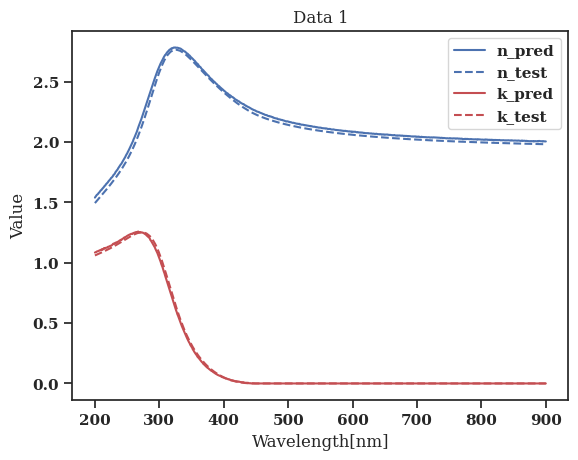

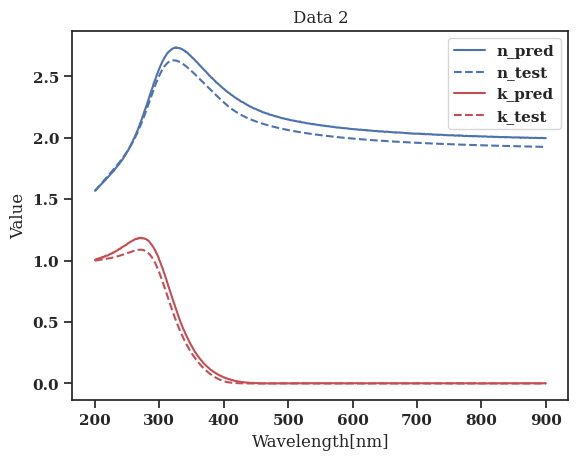

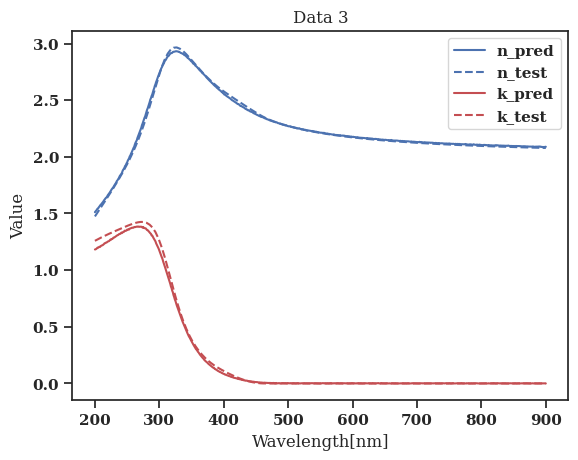

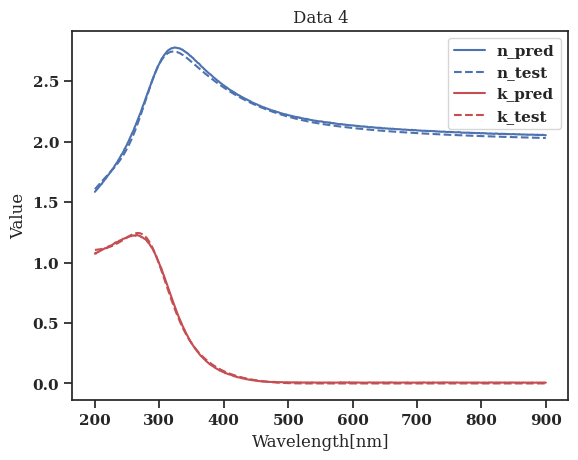

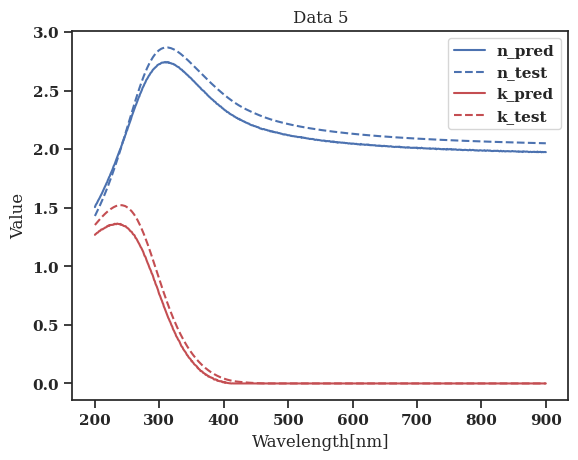

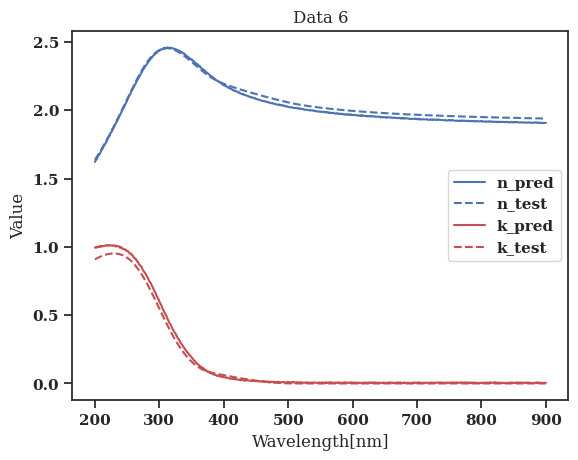

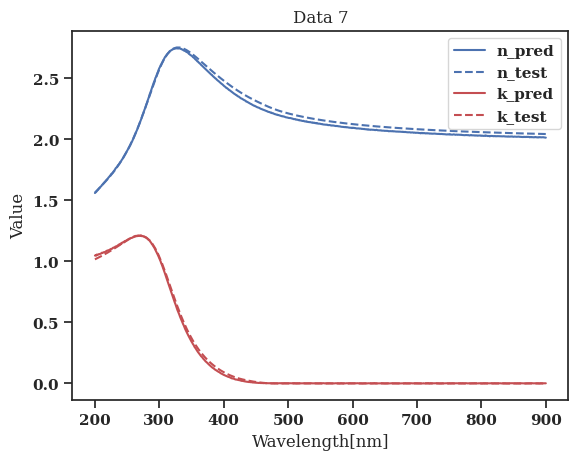

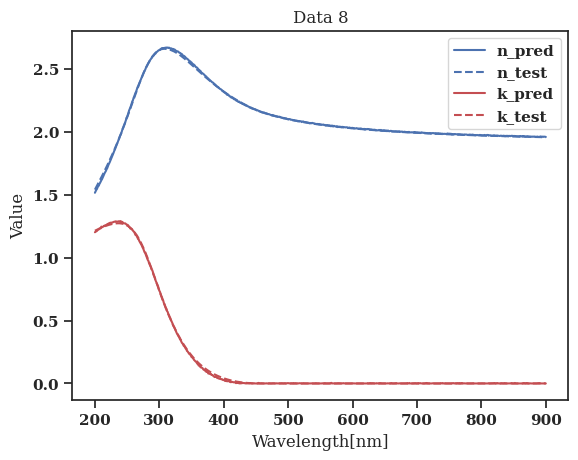

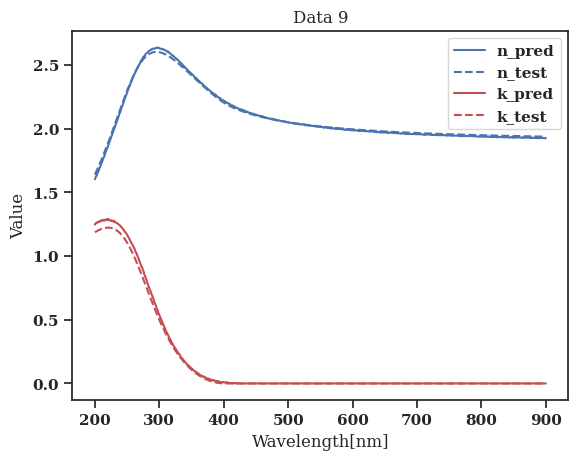

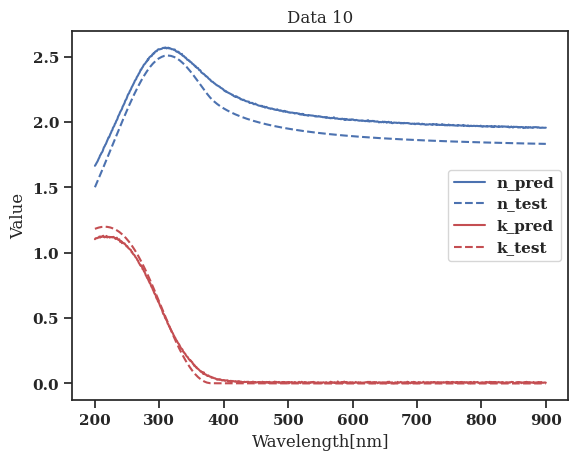

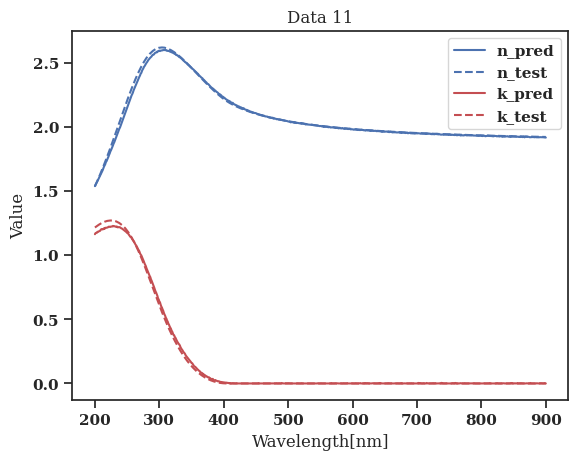

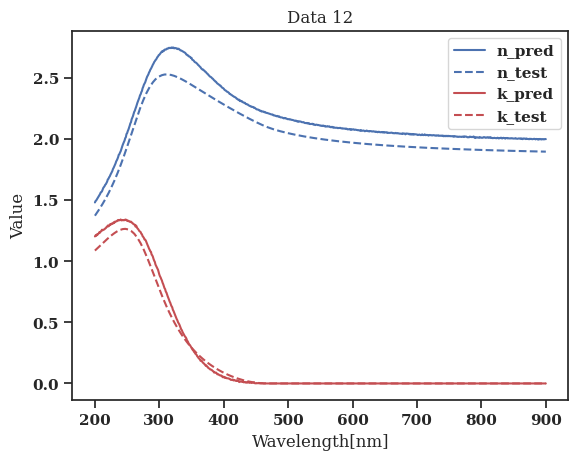

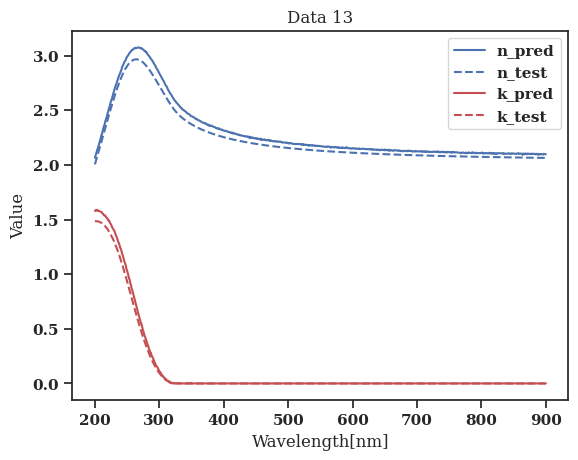

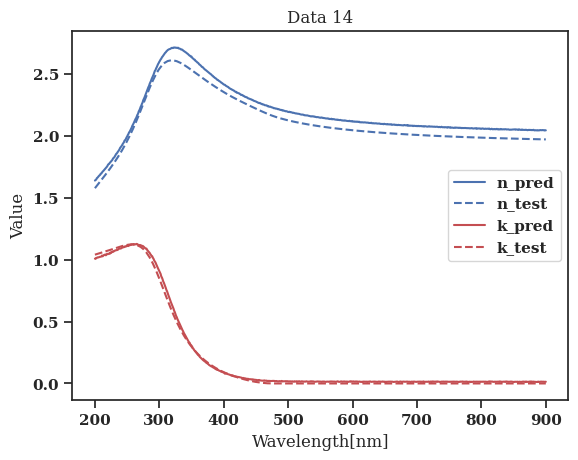

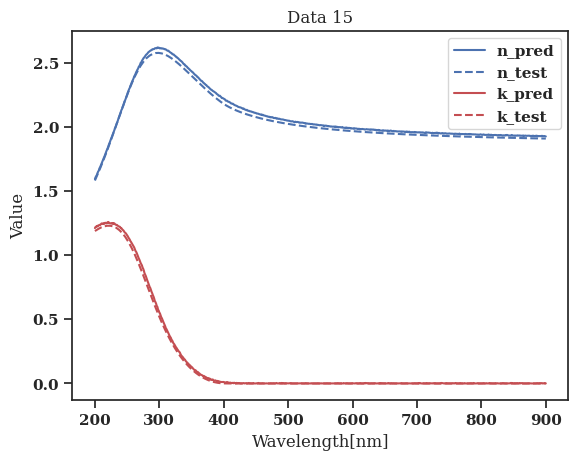

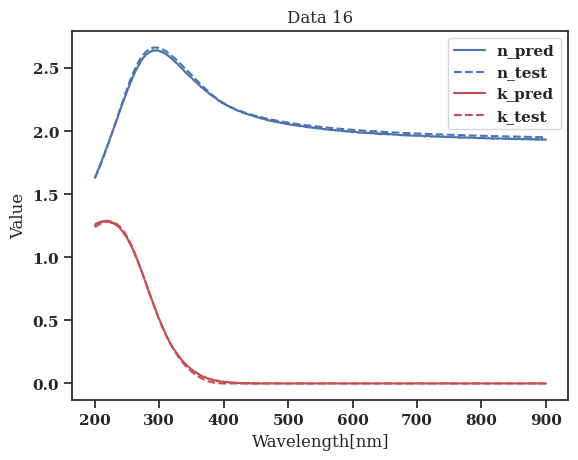

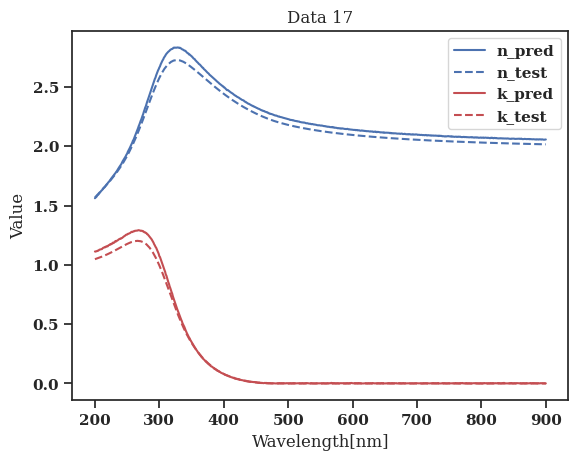

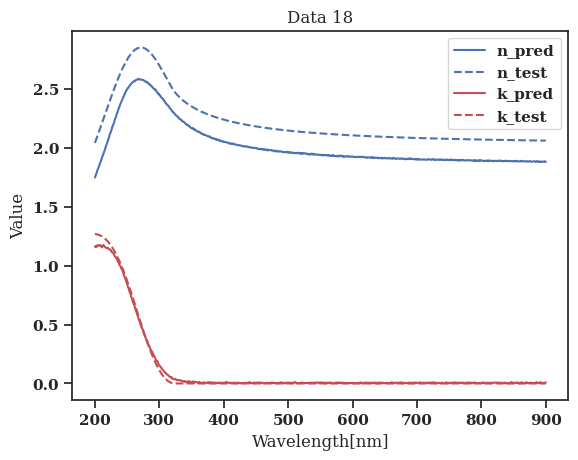

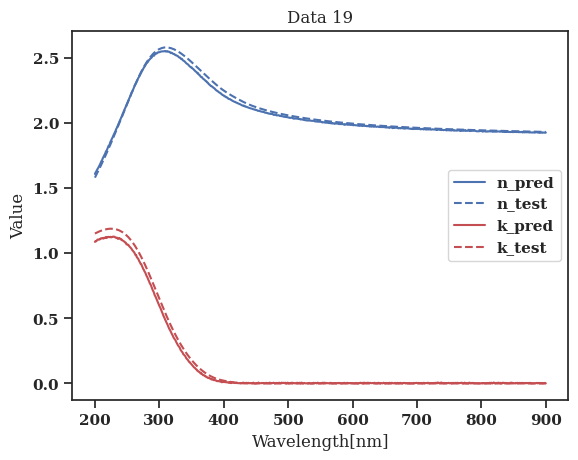

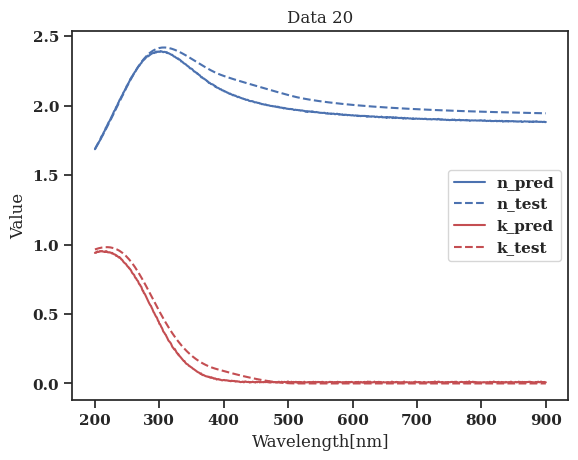

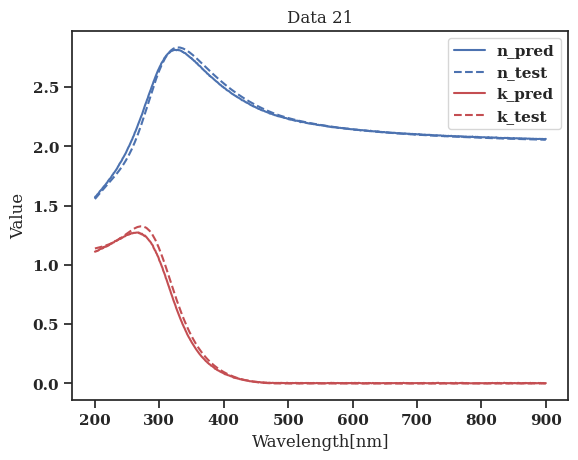

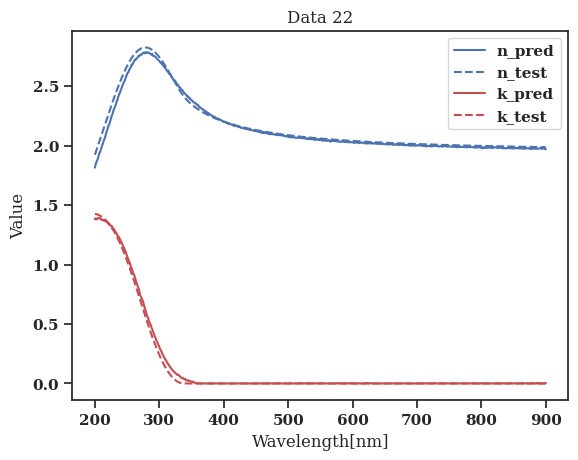

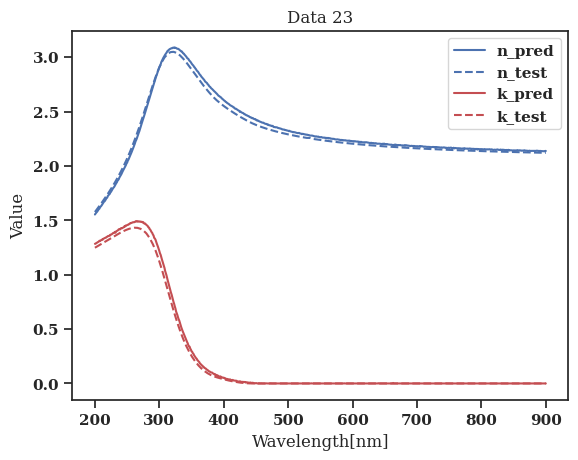

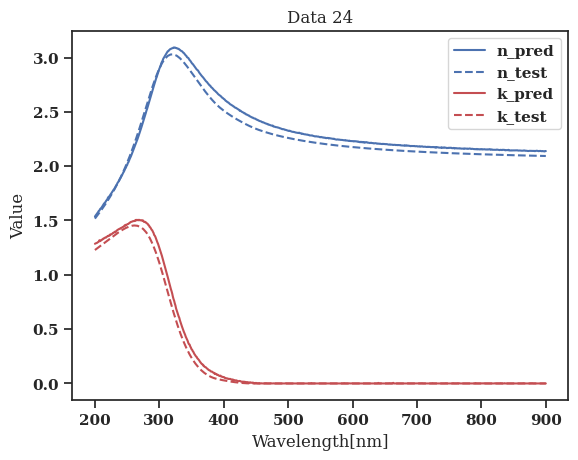

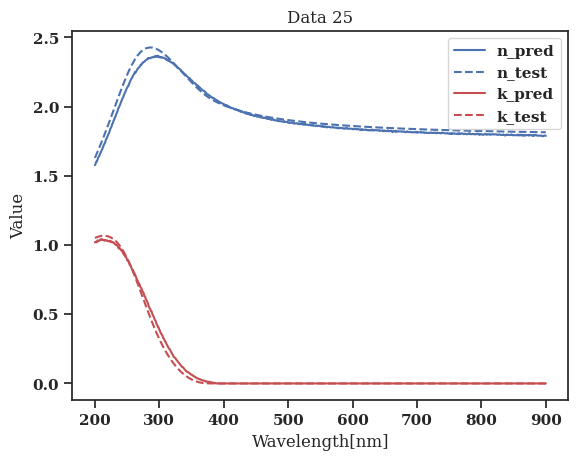

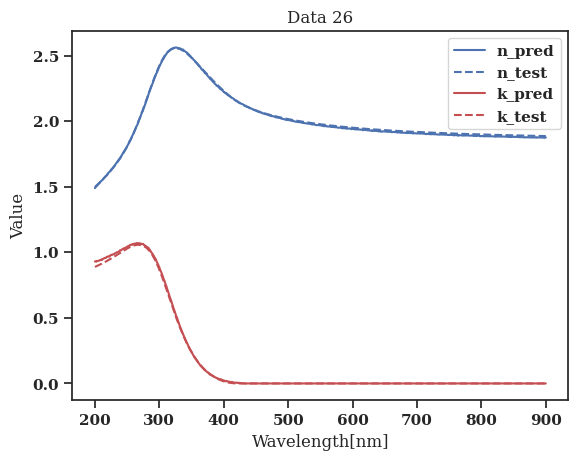

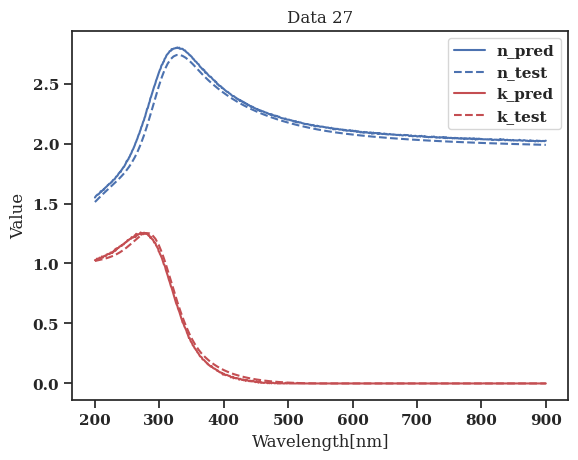

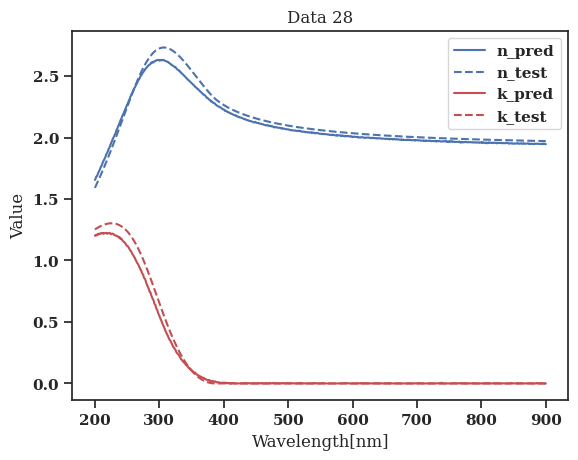

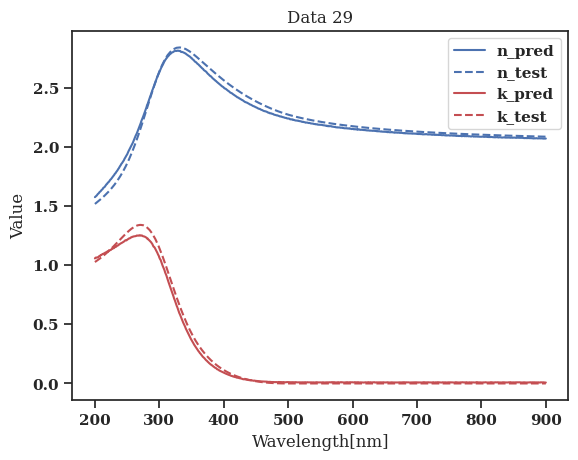

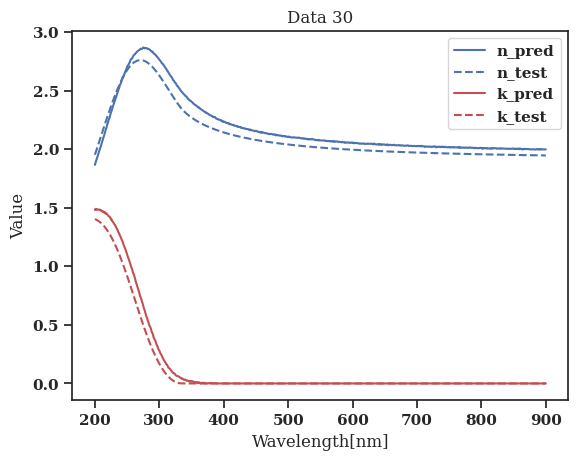

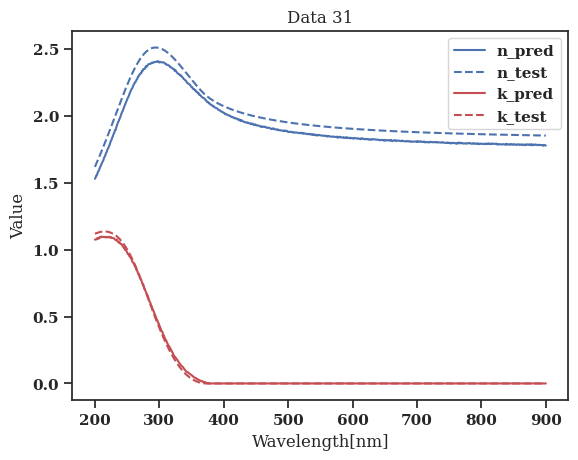

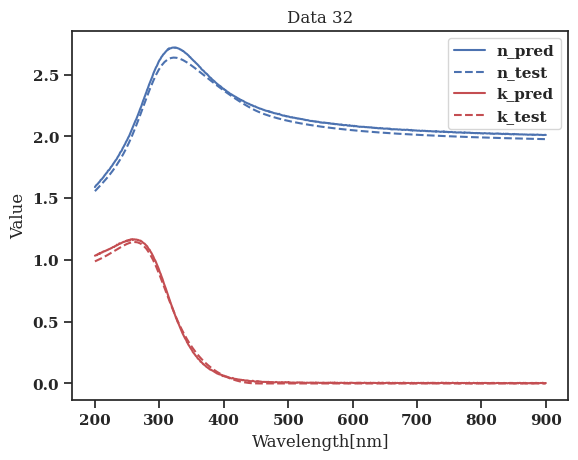

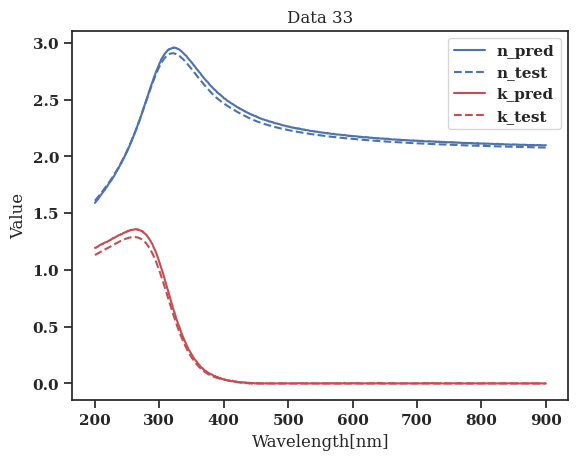

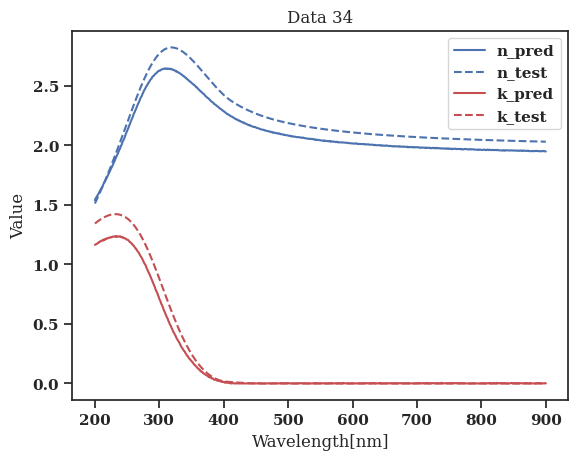

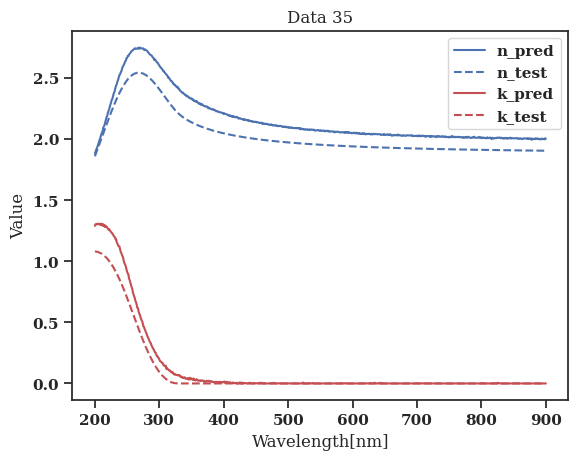

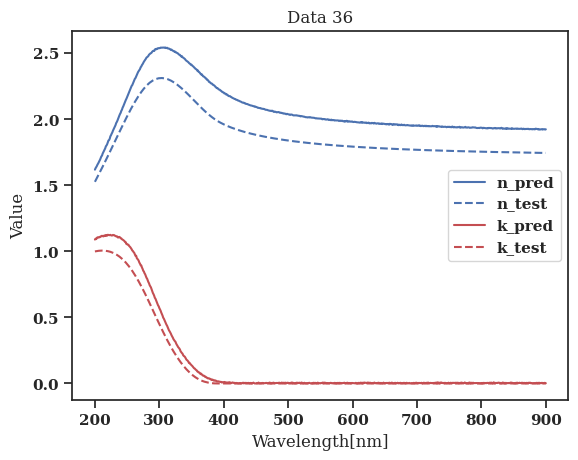

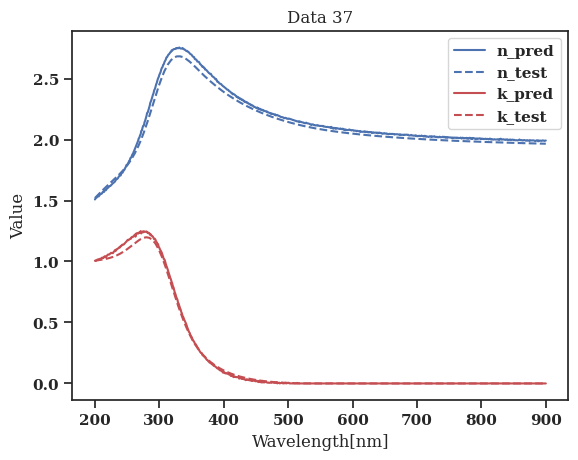

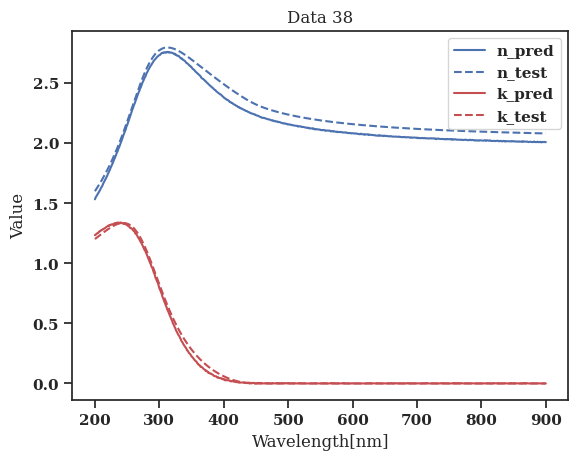

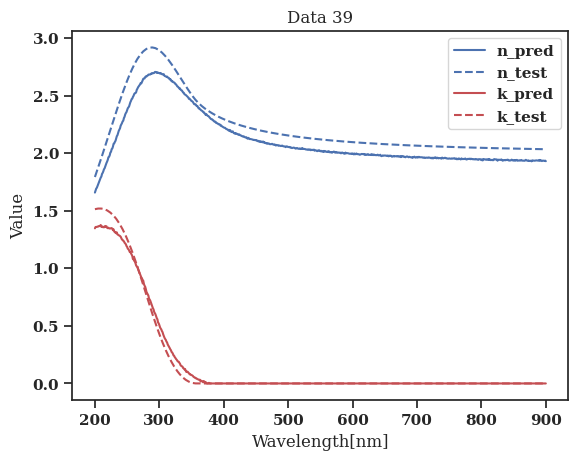

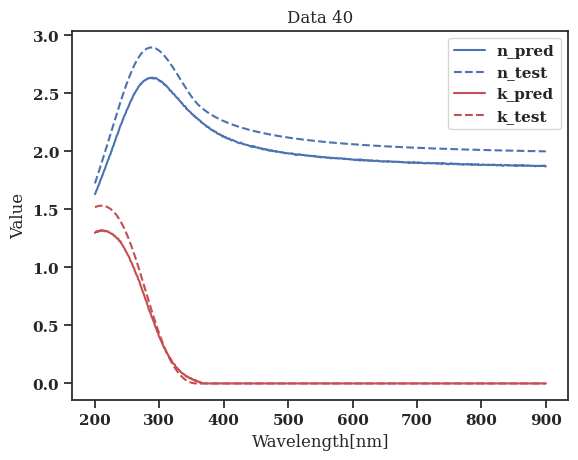

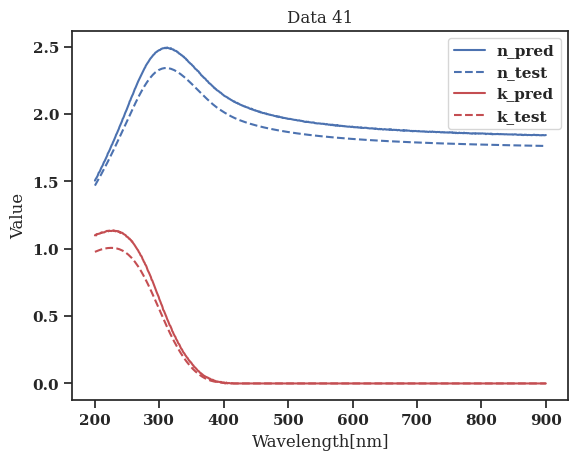

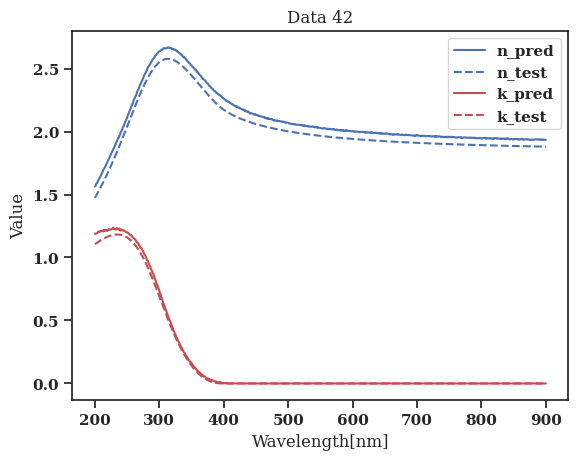

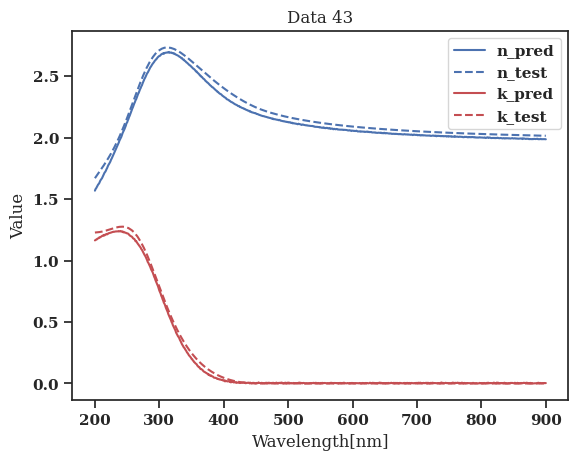

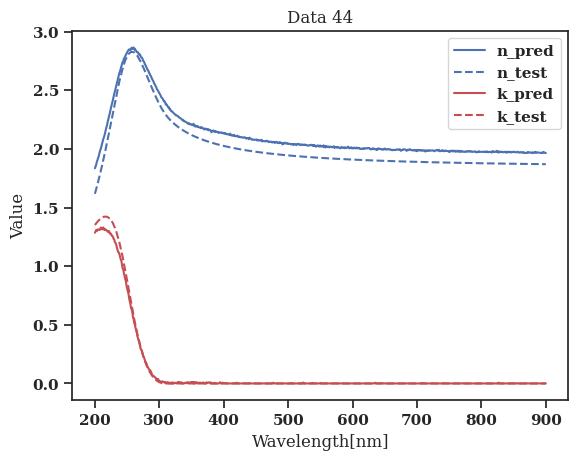

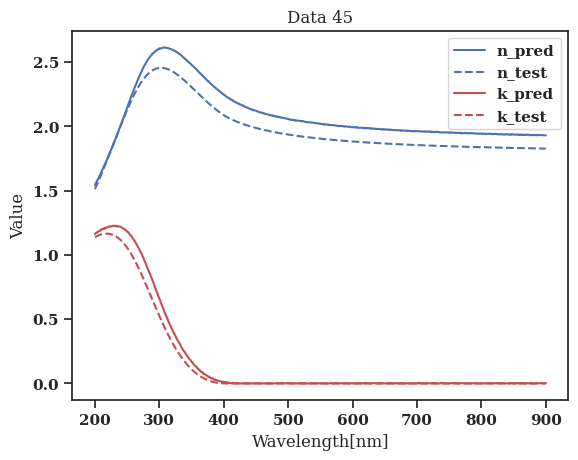

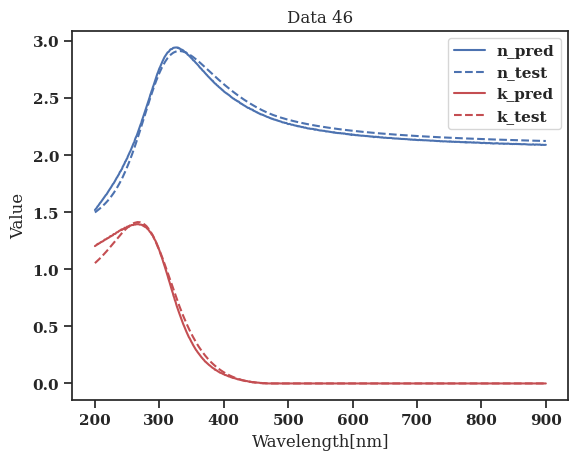

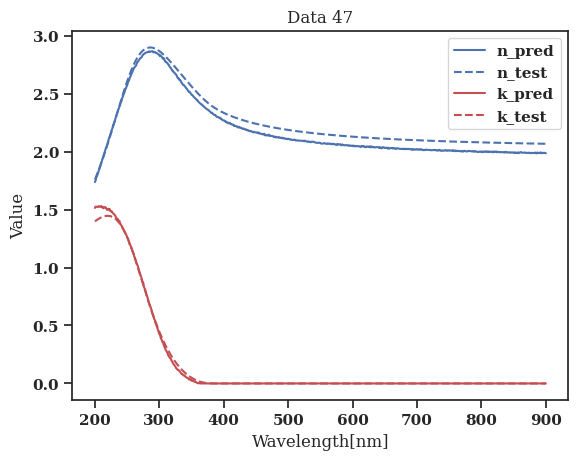

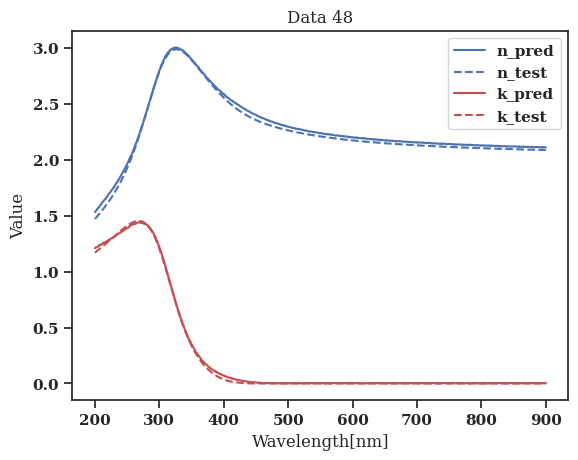

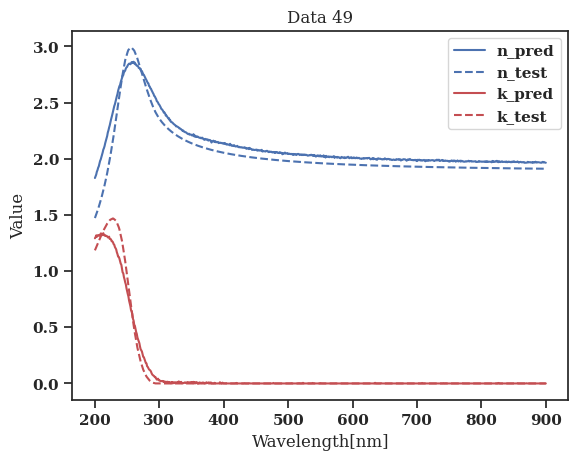

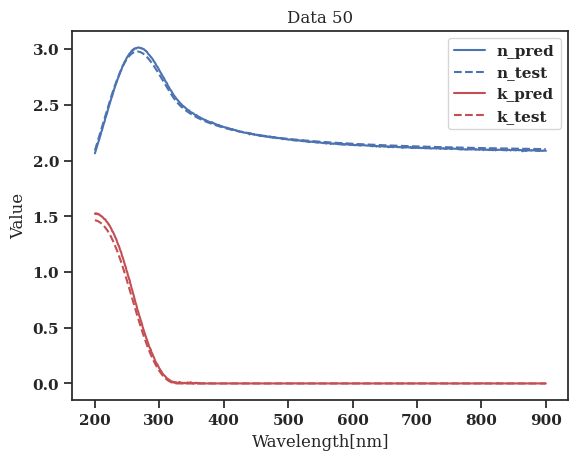

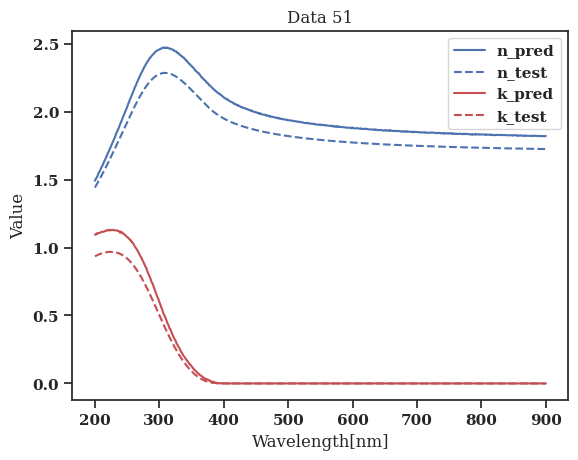

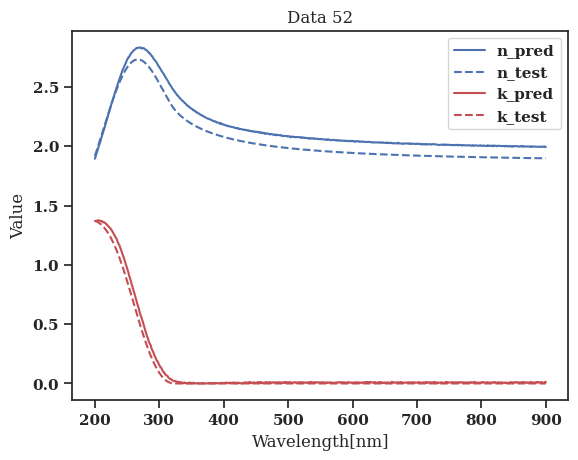

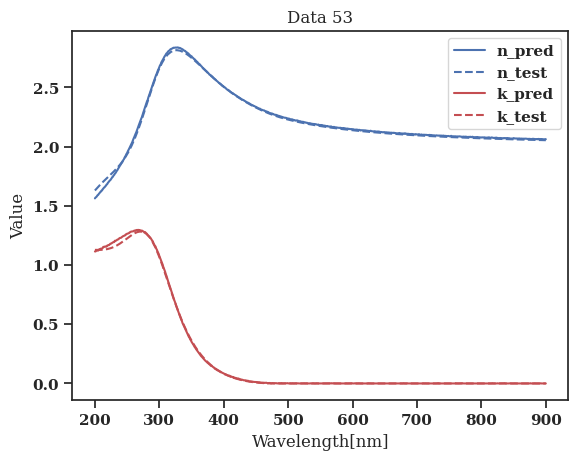

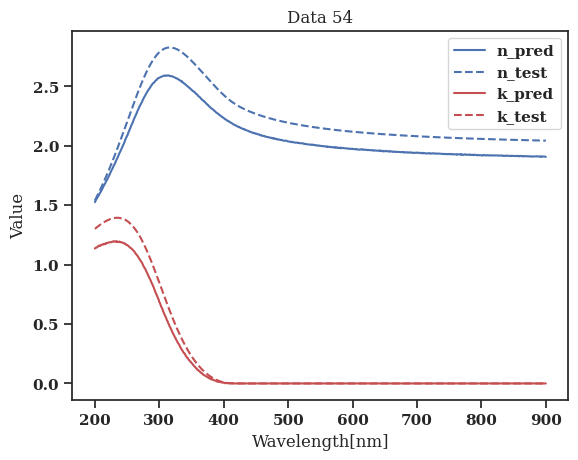

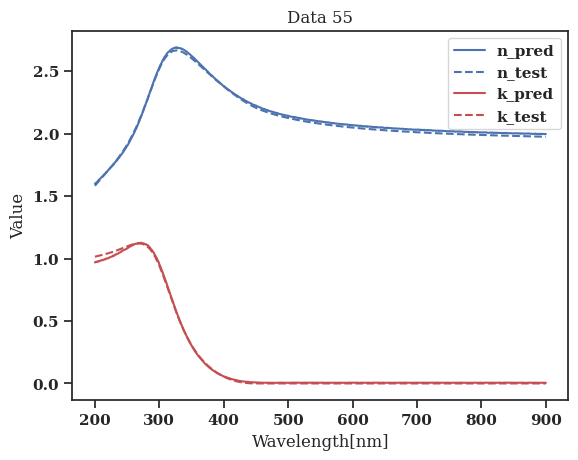

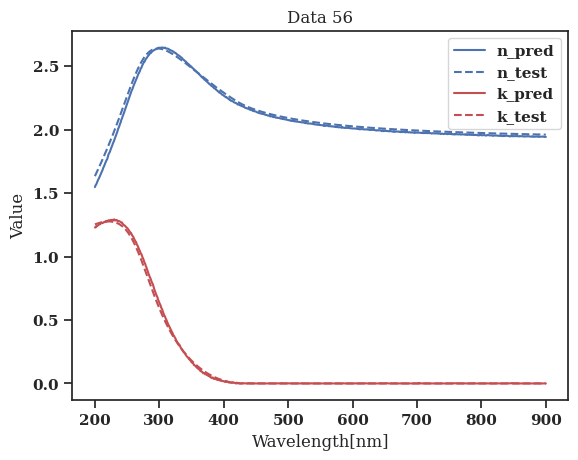

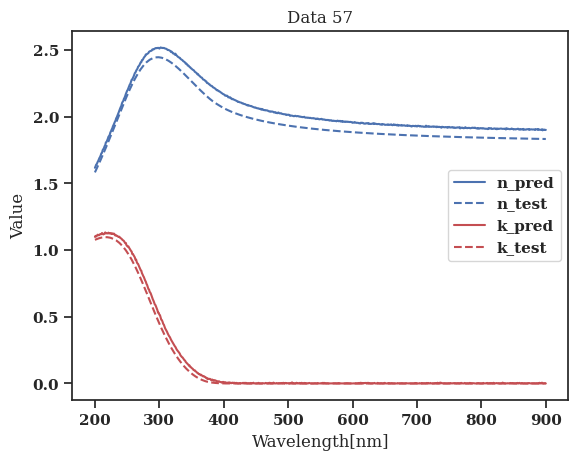

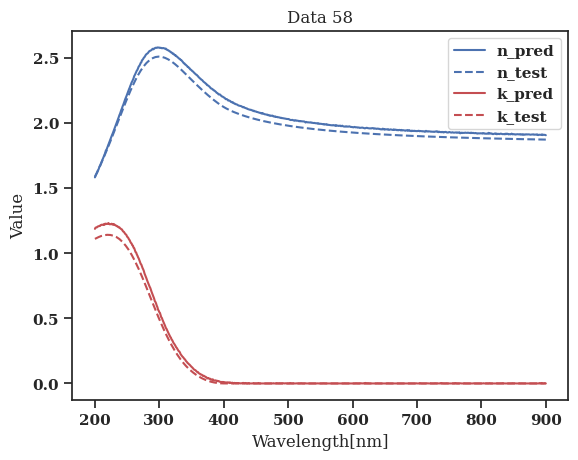

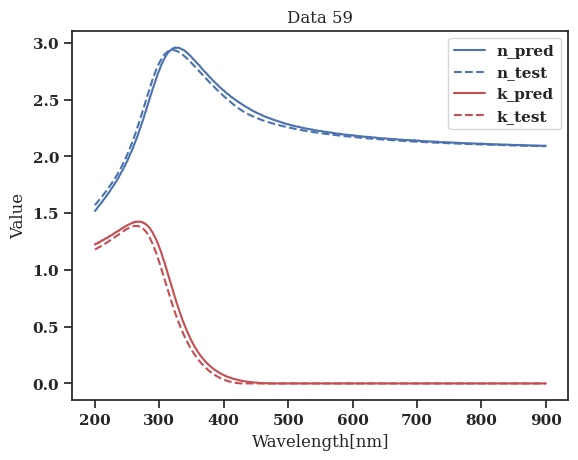

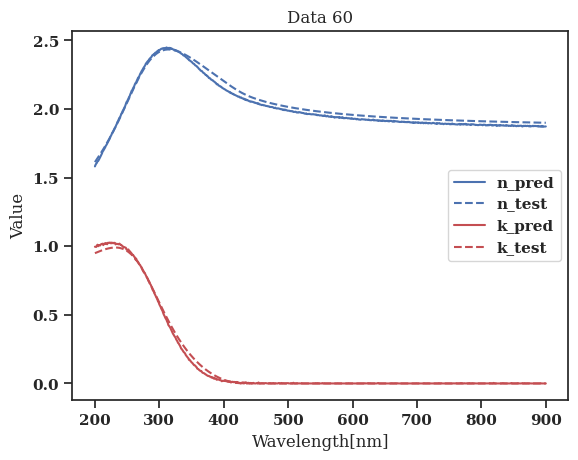

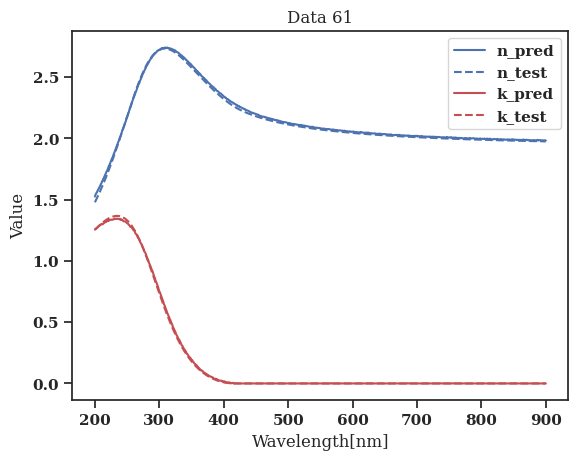

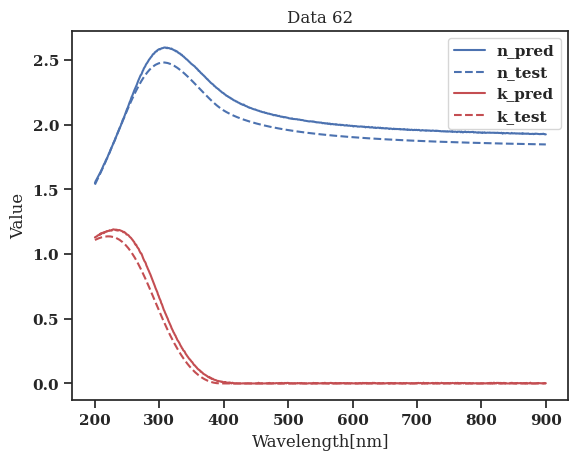

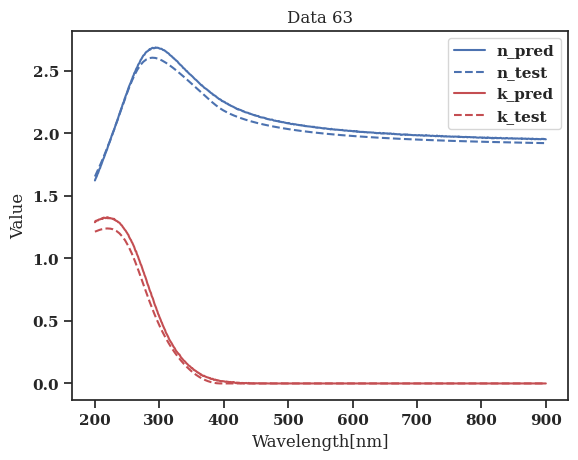

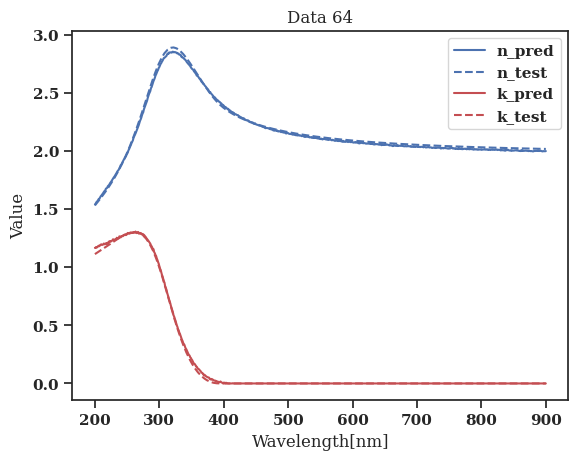

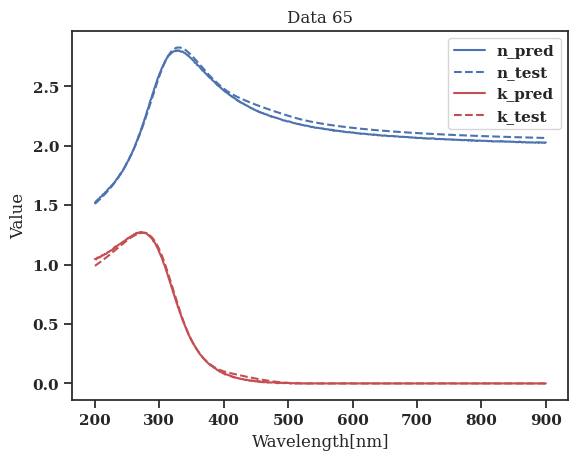

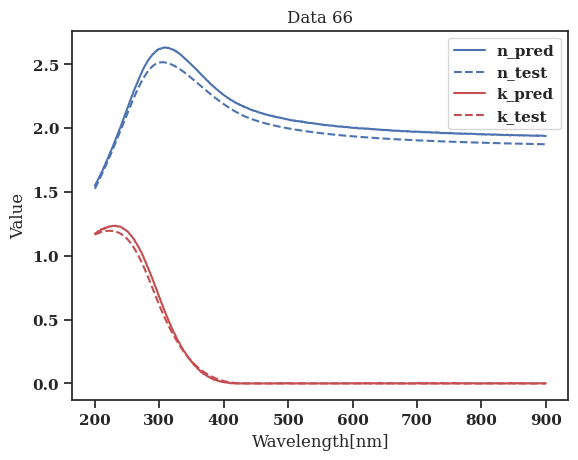

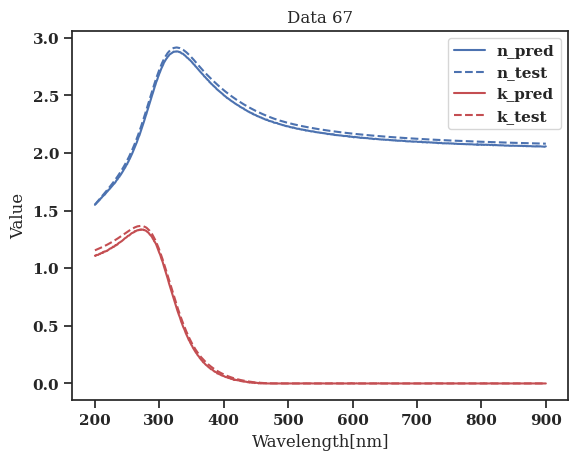

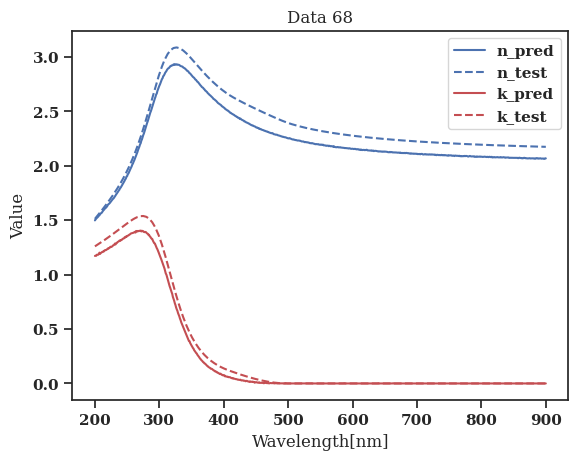

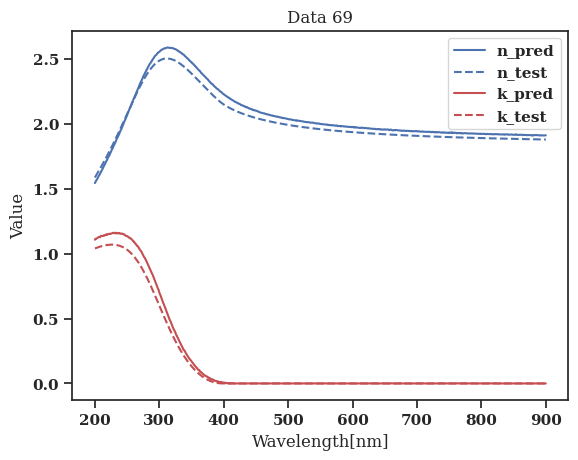

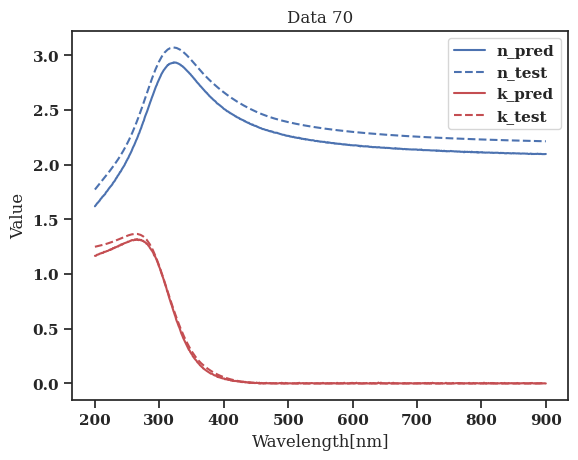

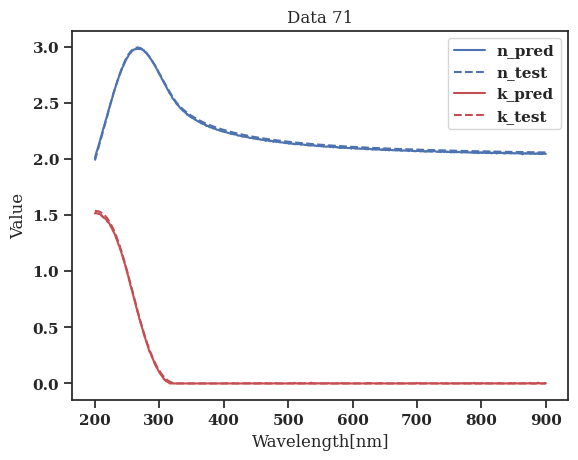

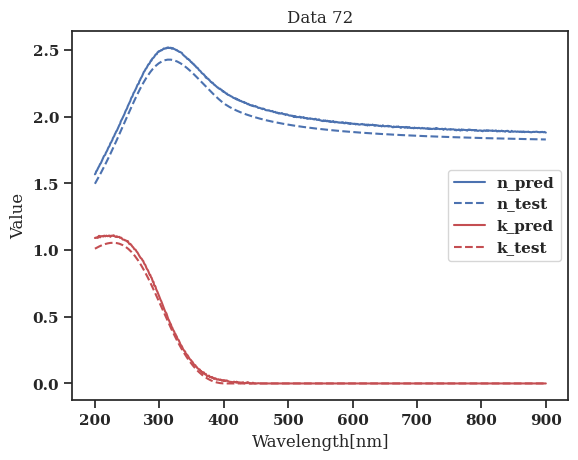

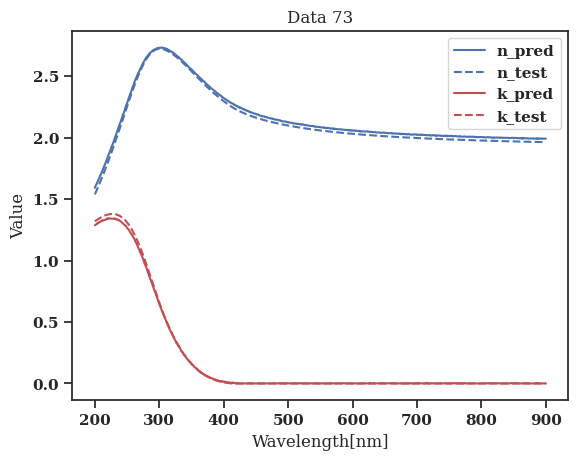

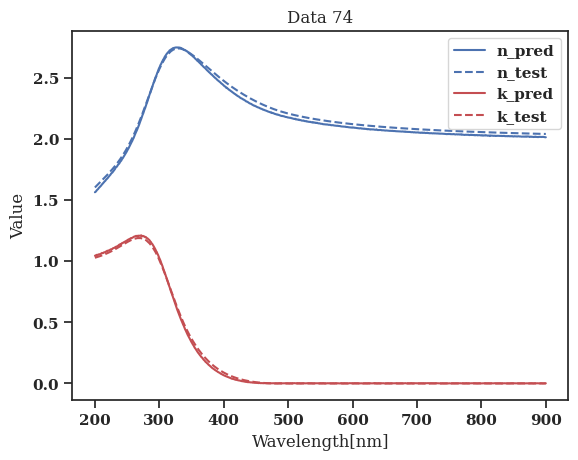

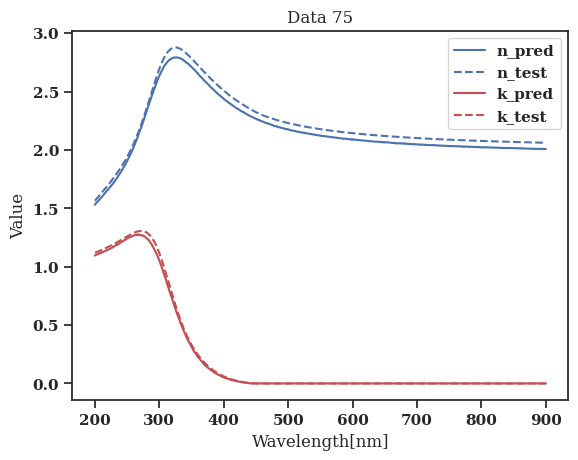

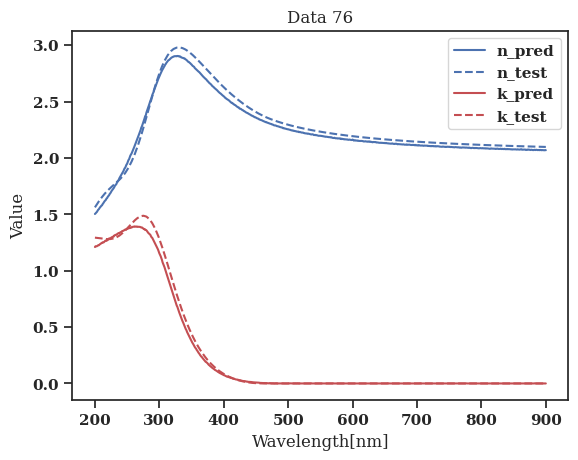

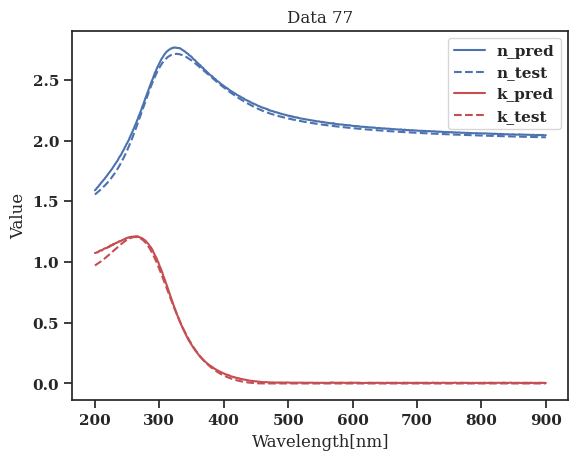

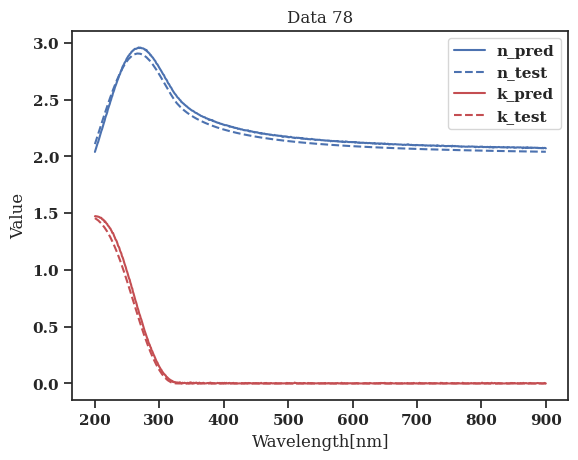

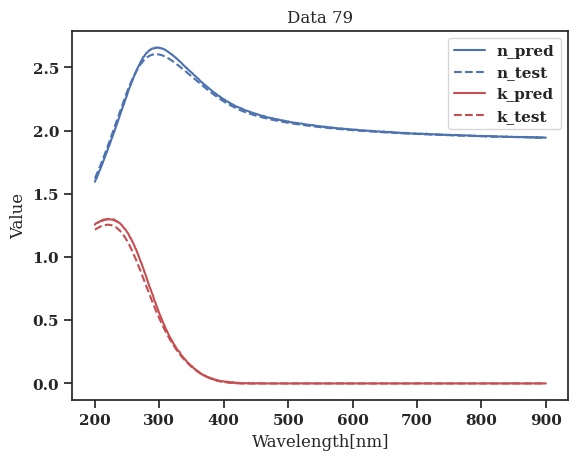

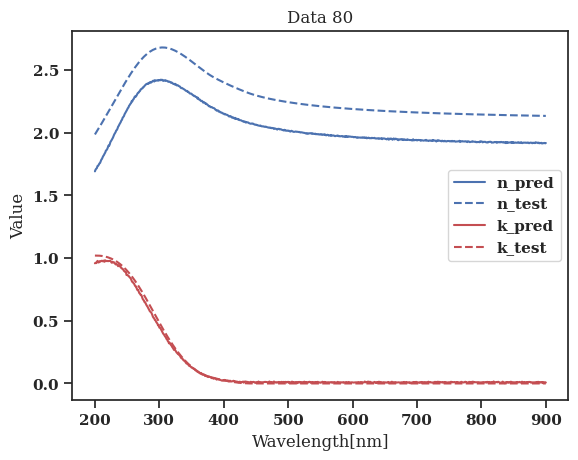

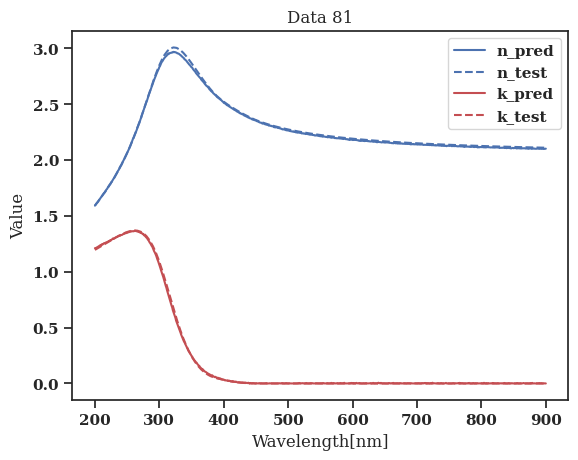

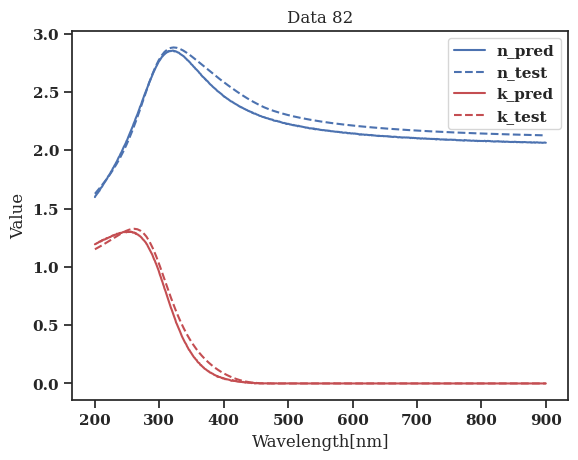

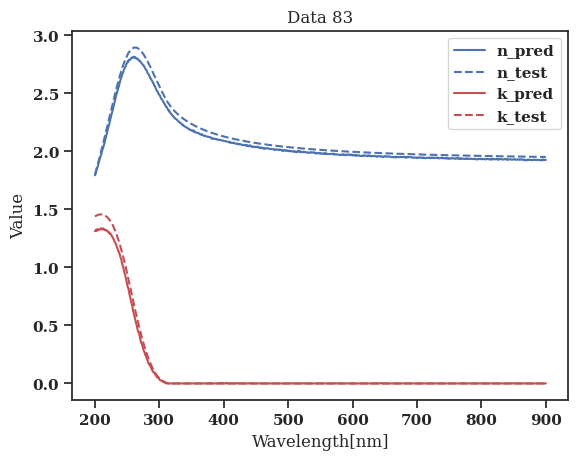

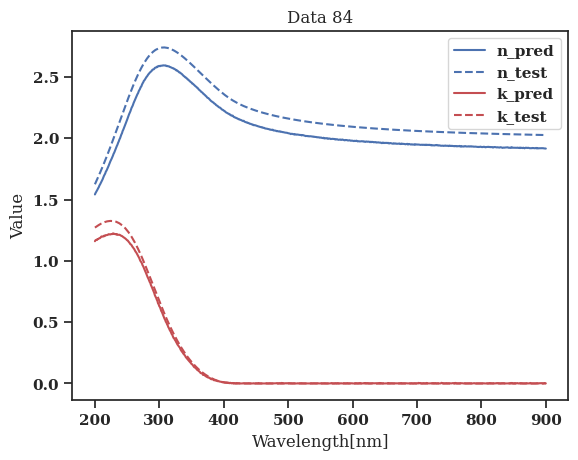

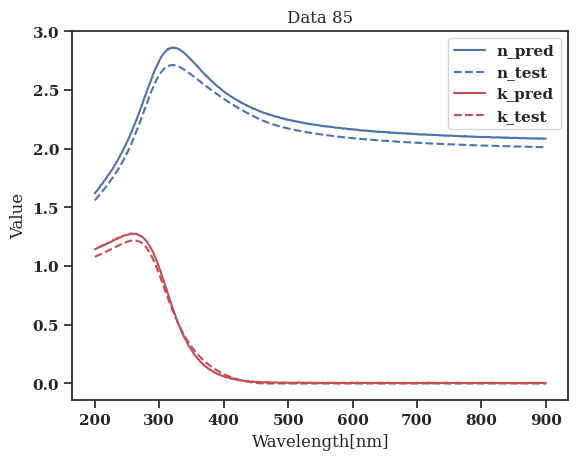

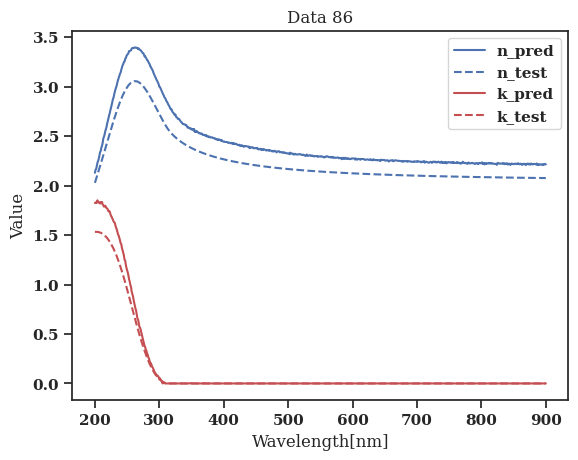

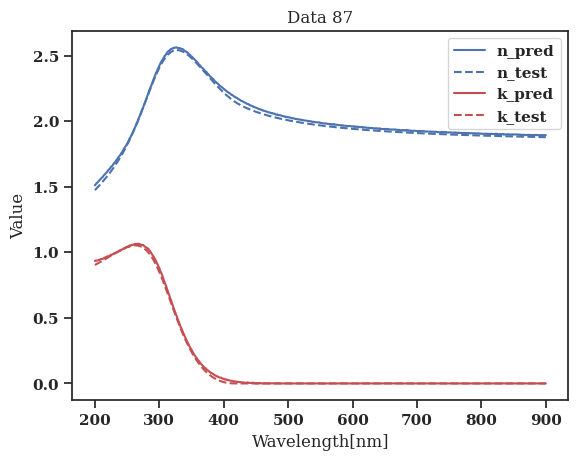

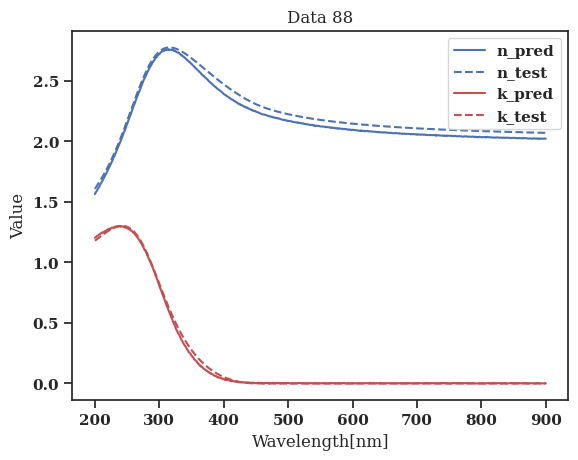

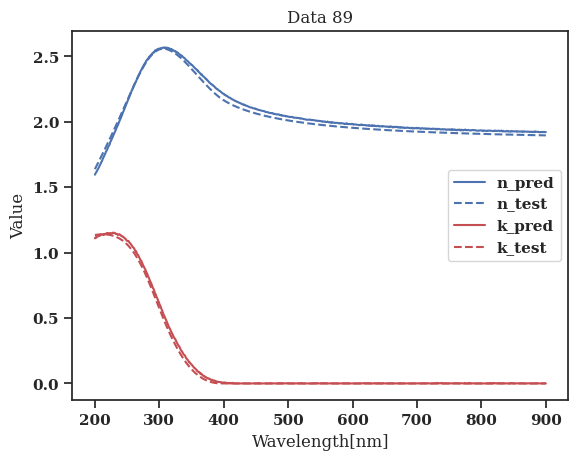

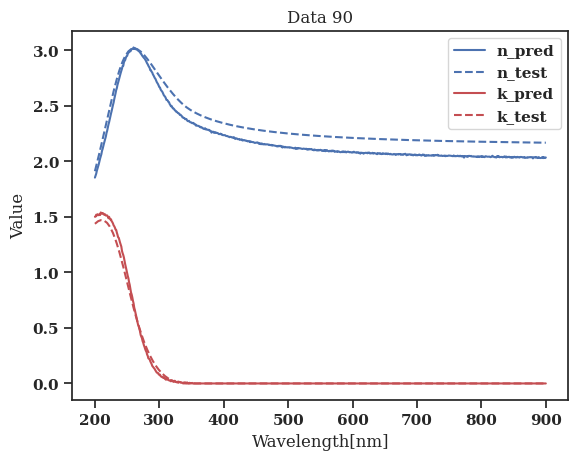

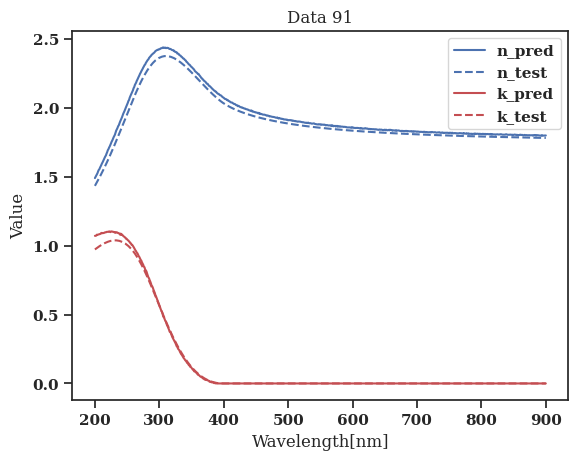

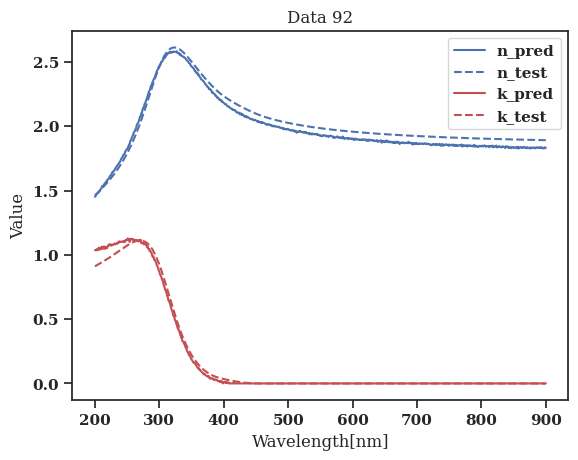

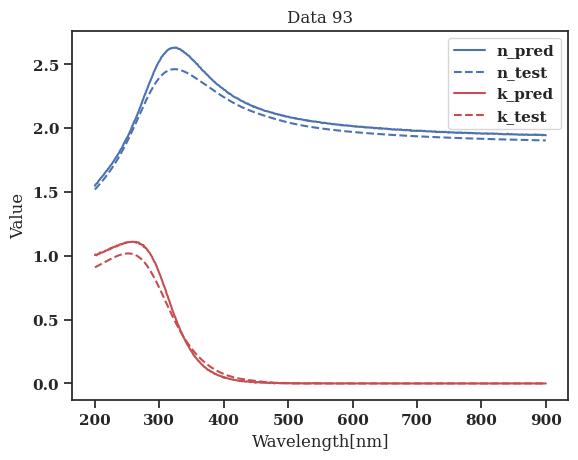

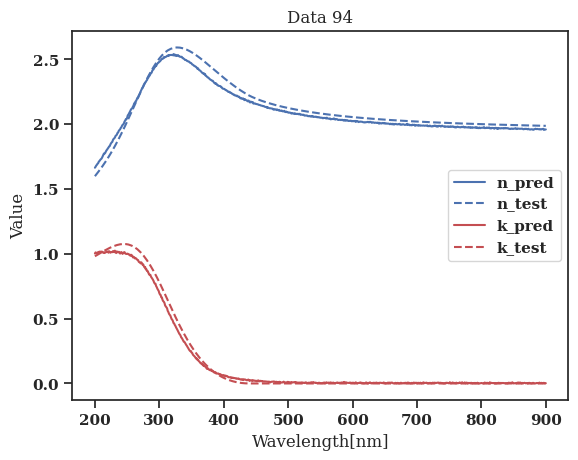

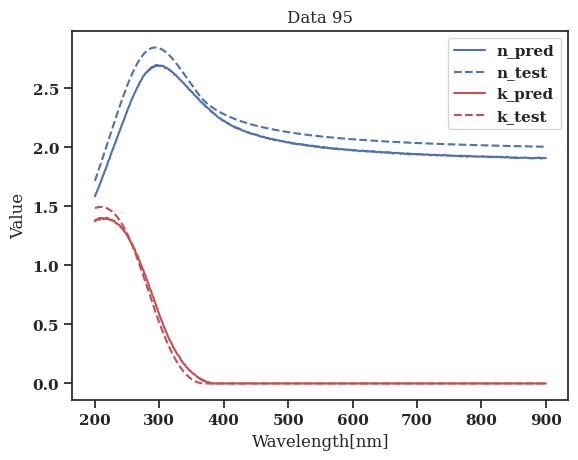

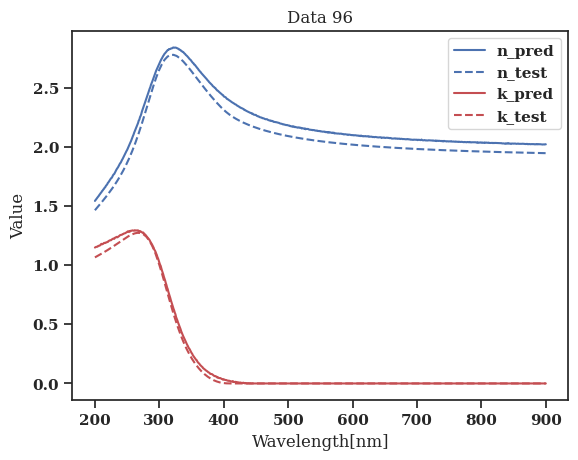

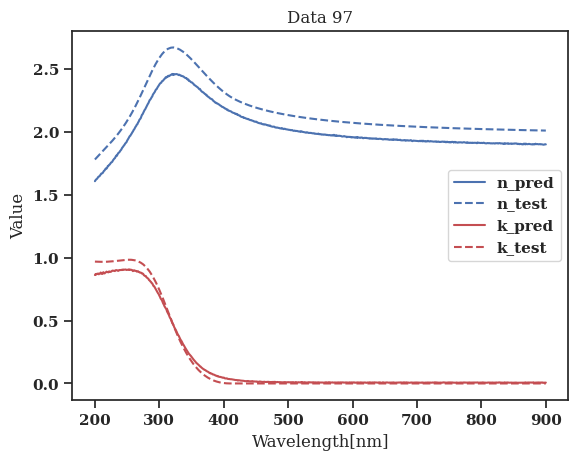

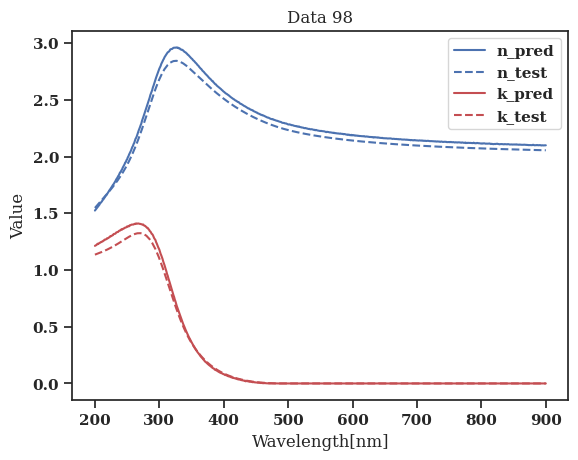

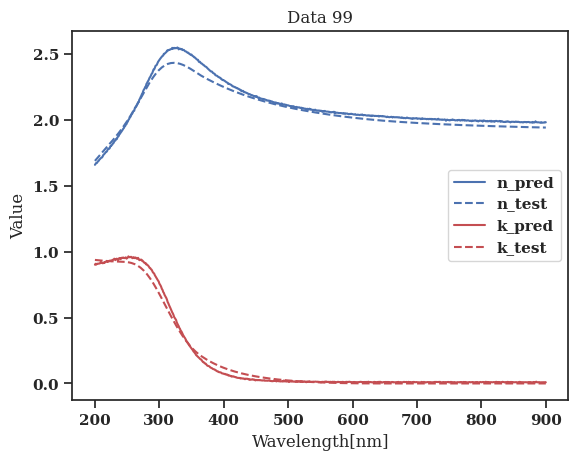

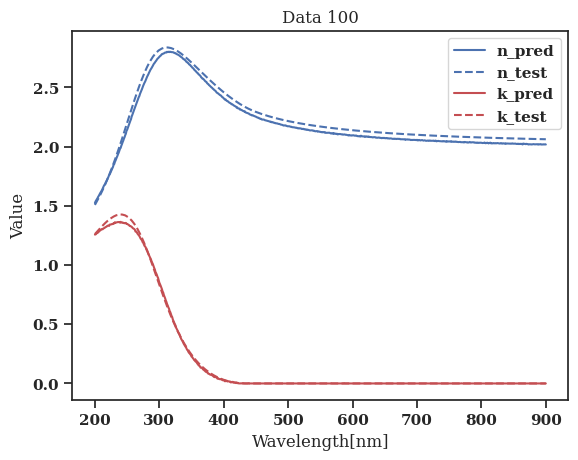

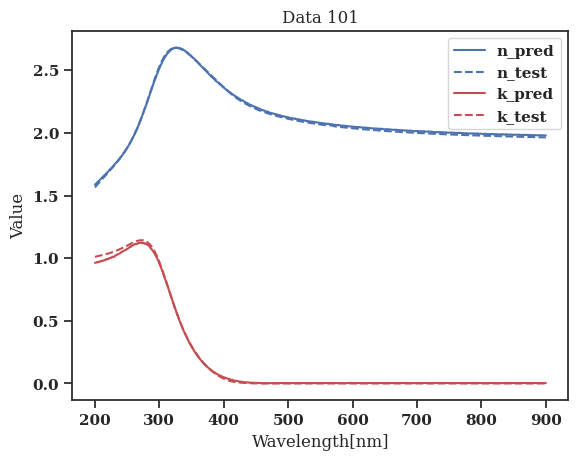

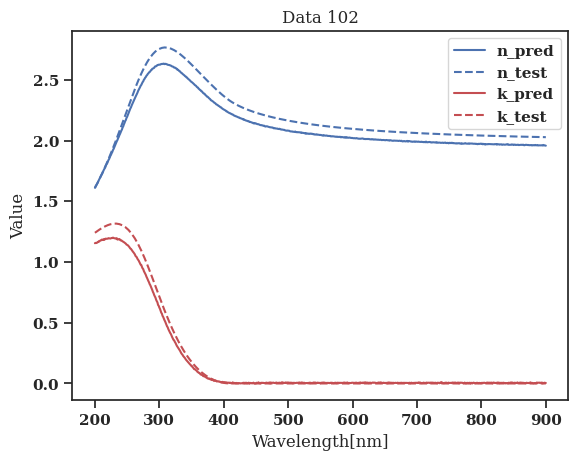

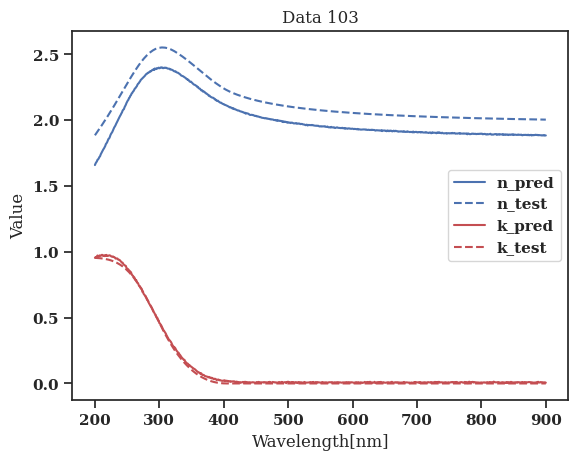

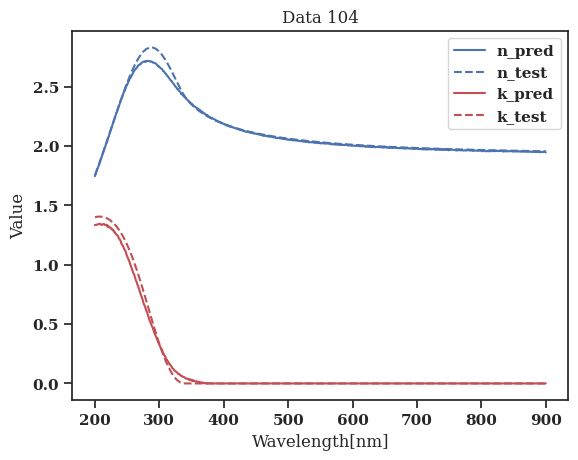

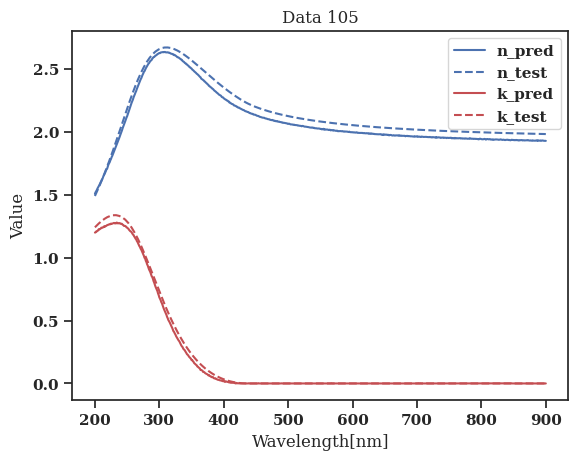

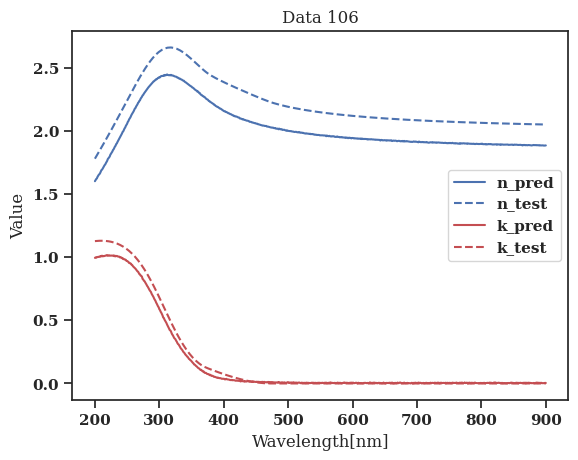

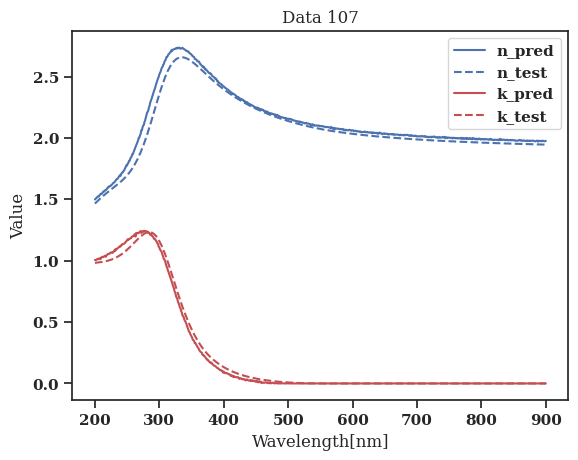

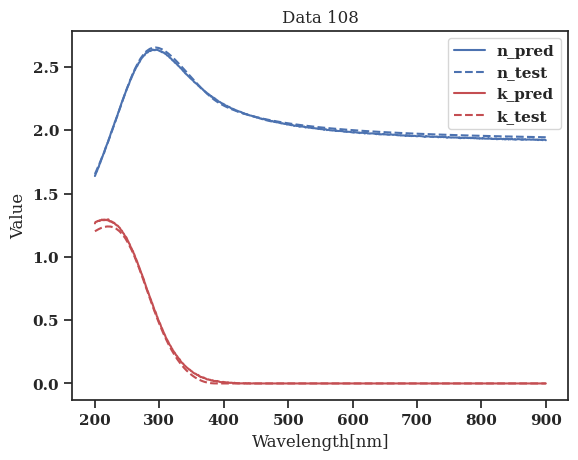

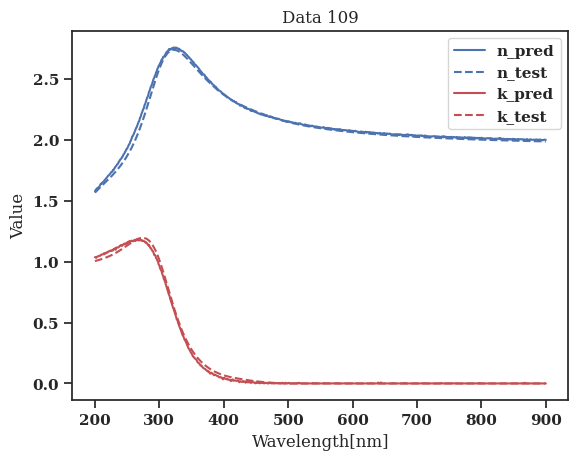

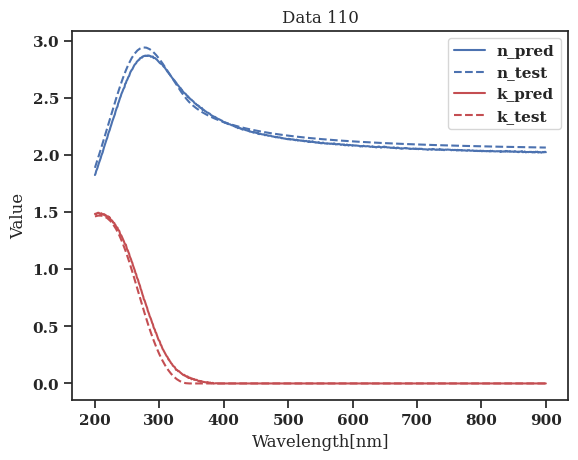

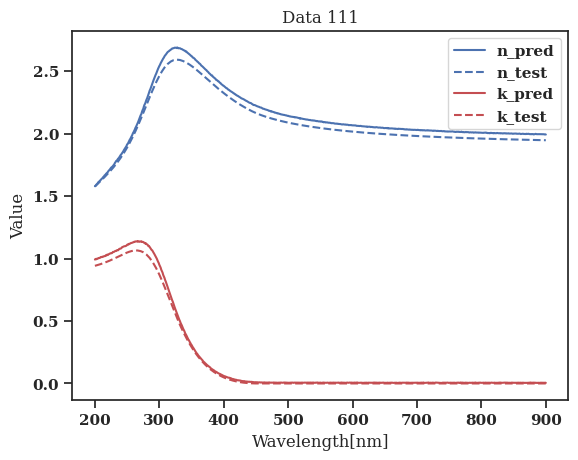

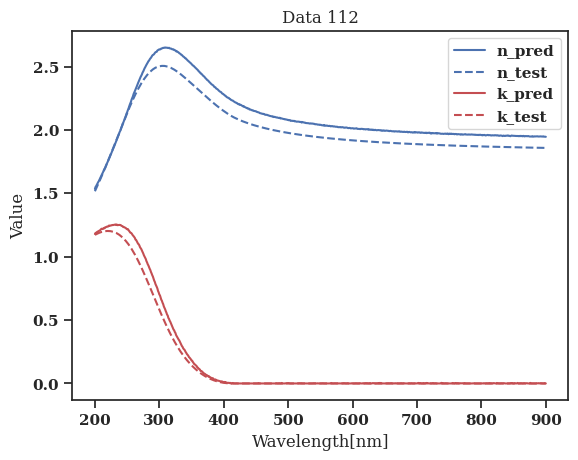

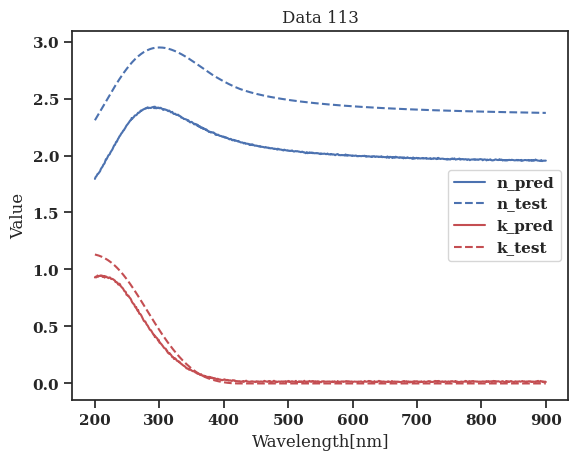

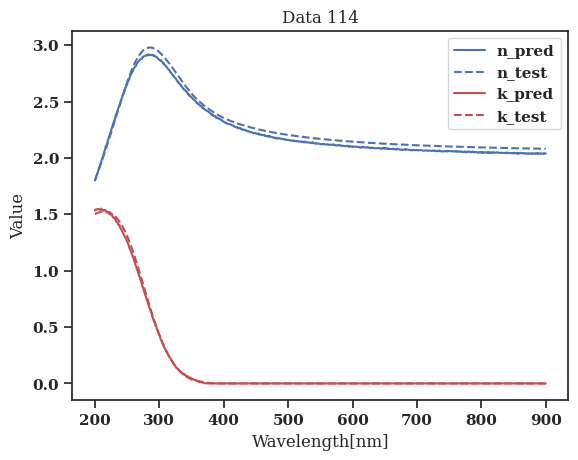

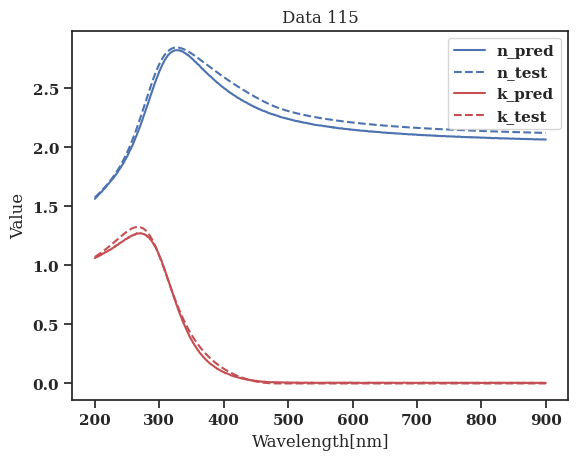

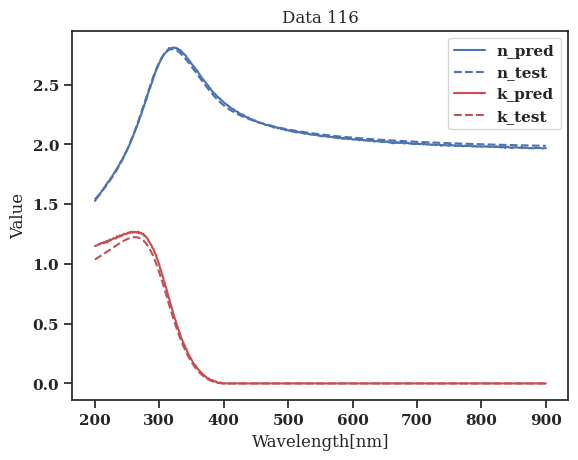

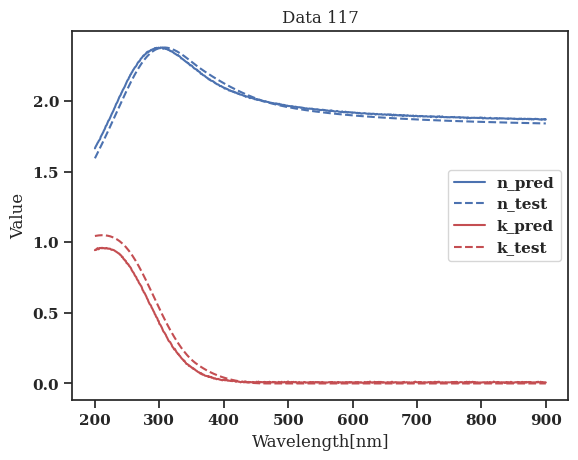

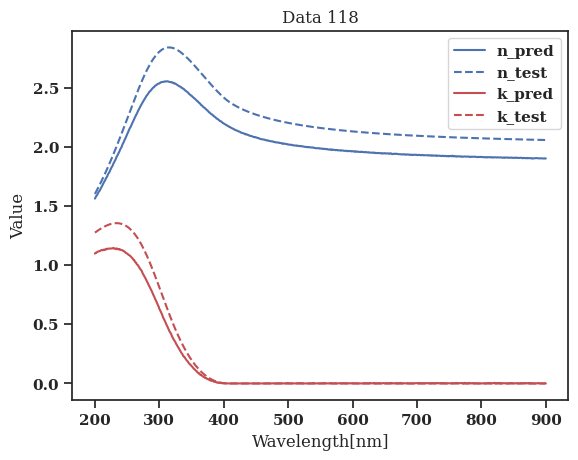

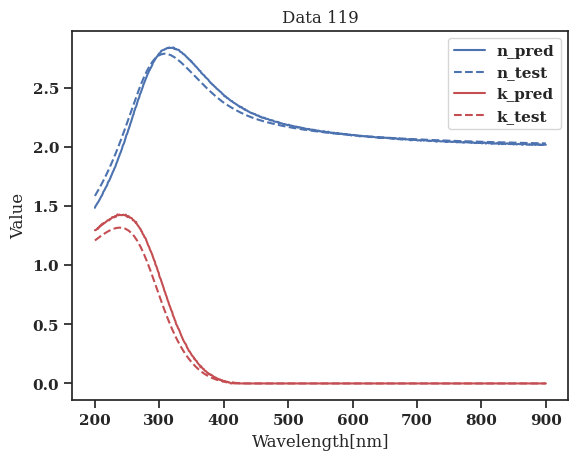

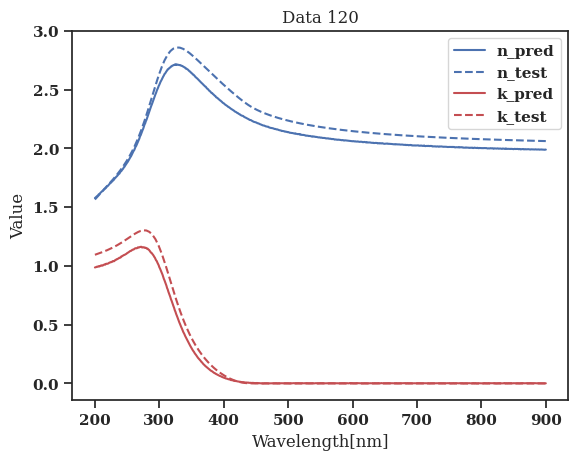

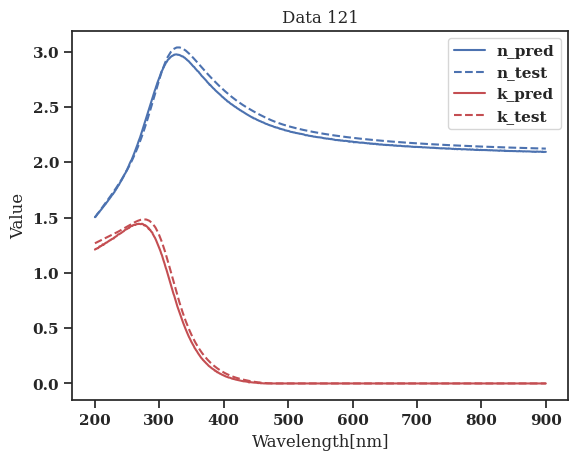

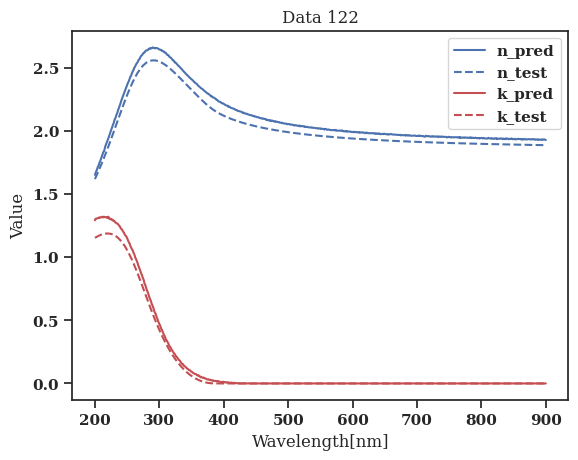

In [63]:
# 生成x坐标轴数据
wavelength = range(200, 901)

# 遍历121个数据，分别绘制四条曲线
for i in range(122):
    plt.figure()
    plt.plot(wavelength, n_pred[i], 'b-', label='n_pred')
    plt.plot(wavelength, n_test[i], 'b--', label='n_test')
    plt.plot(wavelength, k_pred[i], 'r-', label='k_pred')
    plt.plot(wavelength, k_test[i], 'r--', label='k_test')
    
    plt.xlabel('Wavelength[nm]')
    plt.ylabel('Value')
    plt.title('Data {}'.format(i+1))
    plt.legend()
    plt.show()